In [19]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import time, random, os
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

In [20]:
print(tf.__version__)
!python --version

2.8.0
Python 3.8.10


In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
class Episode_experience():
    def __init__(self):
        self.memory = []

    def add(self, state, action, reward, next_state, done, goal):
        self.memory += [(state, action, reward, next_state, done, goal)]

    def clear(self):
        self.memory = []

class DDPGAgent:
    def __init__(self, state_size, action_size, goal_size, action_low=-1, action_high=1, gamma=0.98,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.goal_size = goal_size
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = gamma   # discount rate
        self.memory = []
        self.buffer_size = int(5e4)
        self.a_learning_rate = actor_learning_rate
        self.c_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.tau = tau # soft update
        self.batch_size = 32
        self.gradient_norm_clip = None
        self._construct_nets()

    def _construct_nets(self):
        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.Session()

        self.S = tf.compat.v1.placeholder(tf.float32, [None, self.state_size], 'state')
        self.S_ = tf.compat.v1.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.G = tf.compat.v1.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.D = tf.compat.v1.placeholder(tf.float32, [None, 1], 'done')
        self.R = tf.compat.v1.placeholder(tf.float32, [None, 1], 'r')

        with tf.compat.v1.variable_scope('Actor'):
            self.a = self._build_a(self.S, self.G, scope='eval')
            self.a_ = self._build_a(self.S_, self.G, scope='target')
        with tf.compat.v1.variable_scope('Critic'):
            self.q = self._build_c(self.S, self.a, self.G, scope='eval')
            self.q_ = self._build_c(self.S_, self.a_, self.G, scope='target')

        self.ae_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        self.soft_update_op = [[tf.compat.v1.assign(ta, (1 - self.tau) * ta + self.tau * ea), 
                                tf.compat.v1.assign(tc, (1 - self.tau) * tc + self.tau * ec)]
                    for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + self.gamma * (1-self.D) * self.q_
#         q_target = tf.clip_by_value(q_target, -1/(1-self.gamma), 0)

        self.c_loss = tf.compat.v1.losses.mean_squared_error(q_target, self.q)
        self.a_loss = - tf.reduce_mean(input_tensor=self.q)    # maximize the q

        if self.gradient_norm_clip is not None:
            c_optimizer = tf.compat.v1.train.AdamOptimizer(self.c_learning_rate)
            c_gradients = c_optimizer.compute_gradients(self.c_loss, var_list=self.ce_params)
            for i, (grad, var) in enumerate(c_gradients):
                if grad is not None:
                    c_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.c_train = c_optimizer.apply_gradients(c_gradients)
            a_optimizer = tf.compat.v1.train.AdamOptimizer(self.a_learning_rate)
            a_gradients = c_optimizer.compute_gradients(self.a_loss, var_list=self.ae_params)
            for i, (grad, var) in enumerate(a_gradients):
                if grad is not None:
                    a_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.a_train = a_optimizer.apply_gradients(a_gradients)
        else:
            self.c_train = tf.compat.v1.train.AdamOptimizer(self.c_learning_rate).minimize(self.c_loss, var_list=self.ce_params)
            self.a_train = tf.compat.v1.train.AdamOptimizer(self.a_learning_rate).minimize(self.a_loss, var_list=self.ae_params)

        self.saver = tf.compat.v1.train.Saver()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def _build_a(self, s, g, scope): # policy
        with tf.compat.v1.variable_scope(scope):
            net = tf.concat([s, g], 1)

            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            
            a = tf.compat.v1.layers.dense(net, self.action_size, tf.nn.tanh)
            result = a * (self.action_high-self.action_low)/2 + (self.action_high+self.action_low)/2
            return result

    def _build_c(self, s, a, g, scope): # Q value
        with tf.compat.v1.variable_scope(scope):
            net = tf.concat([s, a, g], 1)
            
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            
            return tf.compat.v1.layers.dense(net, 1)

    def choose_action(self, state, goal, variance): # normal distribution
        action = self.sess.run(self.a, {self.S: state, self.G: goal})[0]
        return np.clip(np.random.normal(action, variance), self.action_low, self.action_high)

    def remember(self, ep_experience):
        self.memory += ep_experience.memory
        if len(self.memory) > self.buffer_size:
            self.memory = self.memory[-self.buffer_size:] # empty the first memories

    def replay(self, optimization_steps=1):
        if len(self.memory) < self.batch_size: # if there's no enough transitions, do nothing
            return 0, 0

        a_losses = 0
        c_losses = 0
        for _ in range(optimization_steps):
            minibatch = np.vstack(random.sample(self.memory, self.batch_size))
            ss = np.vstack(minibatch[:,0])
            acs = np.vstack(minibatch[:,1])
            rs = np.vstack(minibatch[:,2])
            nss = np.vstack(minibatch[:,3])
            ds = np.vstack(minibatch[:,4])
            gs = np.vstack(minibatch[:,5])
            a_loss, _ = self.sess.run([self.a_loss, self.a_train],
                                      {self.S: ss, self.G: gs})
            c_loss, _ = self.sess.run([self.c_loss, self.c_train],
                                      {self.S: ss, self.a: acs, self.R: rs,
                                       self.S_: nss, self.D: ds, self.G: gs})
            a_losses += a_loss
            c_losses += c_loss

        return a_losses/optimization_steps, c_losses/optimization_steps

    def update_target_net(self):
        self.sess.run(self.soft_update_op)

In [23]:
env_name = "TouchCube"
    
try:
    env.close()
except:
    pass

from mlagents_envs.environment import UnityEnvironment

env = UnityEnvironment(file_name=env_name)
env.reset()

[INFO] Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


[INFO] Connected new brain: TouchCube?team=0


INFO:mlagents_envs.environment:Connected new brain: TouchCube?team=0


In [24]:
brain_name = list(env.behavior_specs)[0]#env.brain_names[0]
brain = env.behavior_specs[brain_name]#env.brains[brain_name]
decision_steps, terminal_steps = env.get_steps(brain_name)
# Note : len(decision_steps) = [number of agents that requested a decision]

num_agents = len(decision_steps)
print("num agents ", num_agents)

if brain.action_spec.discrete_size > 0:
    for action, branch_size in enumerate(brain.action_spec.discrete_branches):
        print(f"Action number {action} has {branch_size} different options")
        state_size = branch_size

action_size = brain.action_spec.continuous_size
print("action size ", action_size)

decision_steps, terminal_steps = env.get_steps(brain_name)
state_size = len(decision_steps.obs[0][0])
print("state size ", state_size)

print("Agent state looks like: \n{}".format(decision_steps.obs[0]))

num agents  1
action size  3
state size  12
Agent state looks like: 
[[ 0.2430497   0.          0.37310985  0.2430497  -0.83987963  0.37310985
   0.          0.83987963  0.          0.         -0.         -0.        ]]


In [25]:
def reward_func(state, goal):
    hand = state[3:6]
    dist = np.linalg.norm(hand-goal)*5 # range=5
    
    done = False
    reward = -1
    if dist<=1:
        done = True
        reward = 1
    return done, reward

# DDPG agent

In [26]:
agent = DDPGAgent(state_size= state_size - 3, action_size=action_size, goal_size=3, action_high=10,
                  action_low=-10, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

## With HER

epoch 1 success rate 0.27 ep_mean_r -3431.53 exploration 4.78          

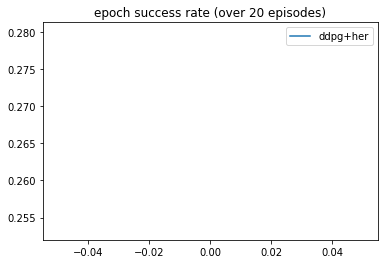

epoch 2 success rate 0.27 ep_mean_r -1479.17 exploration 4.58          

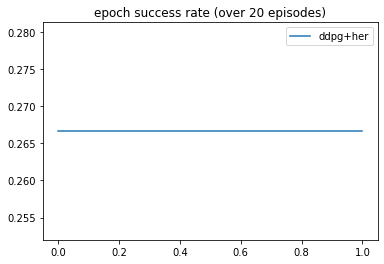

epoch 3 success rate 0.43 ep_mean_r -807.73 exploration 4.40          

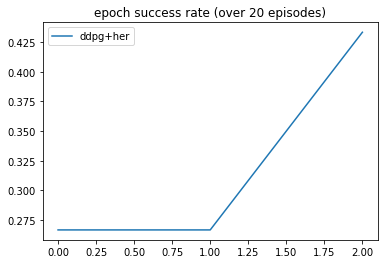

epoch 4 success rate 0.90 ep_mean_r -447.87 exploration 4.28          

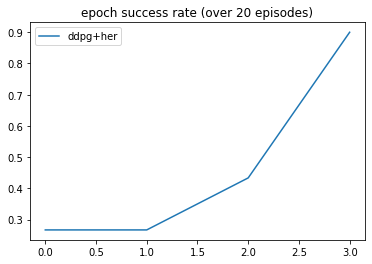

epoch 5 success rate 0.90 ep_mean_r -469.07 exploration 4.17          

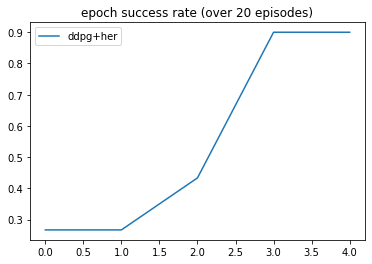

epoch 6 success rate 1.00 ep_mean_r -220.70 exploration 4.07          

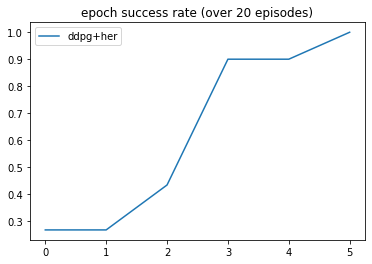

epoch 7 success rate 1.00 ep_mean_r -409.73 exploration 3.97          

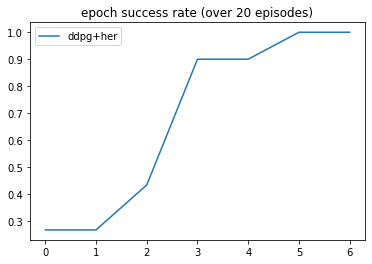

epoch 8 success rate 1.00 ep_mean_r -224.63 exploration 3.89          

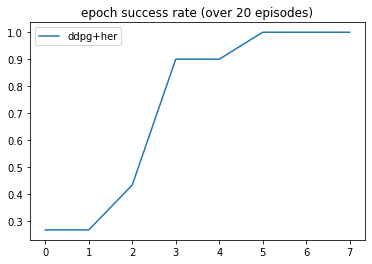

epoch 9 success rate 1.00 ep_mean_r -122.63 exploration 3.82          

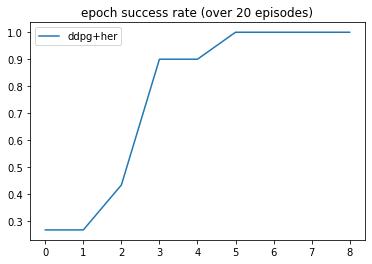

epoch 10 success rate 1.00 ep_mean_r -144.13 exploration 3.75          

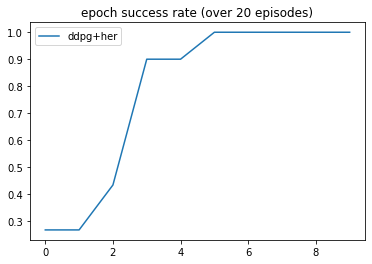

epoch 11 success rate 1.00 ep_mean_r -113.07 exploration 3.69          

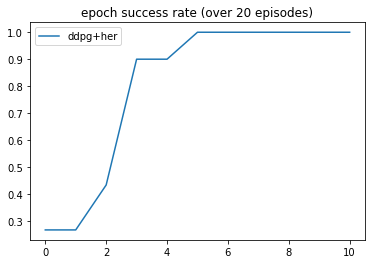

epoch 12 success rate 1.00 ep_mean_r -87.30 exploration 3.63          

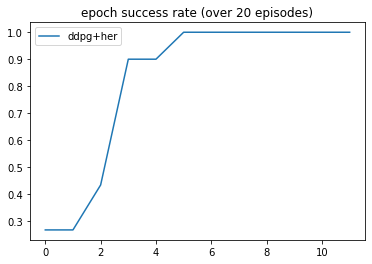

epoch 13 success rate 1.00 ep_mean_r -67.27 exploration 3.56          

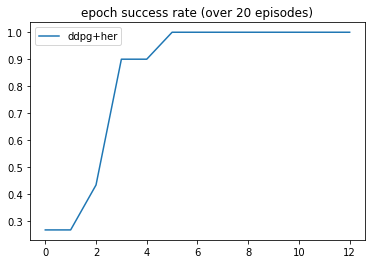

epoch 14 success rate 1.00 ep_mean_r -67.40 exploration 3.51          

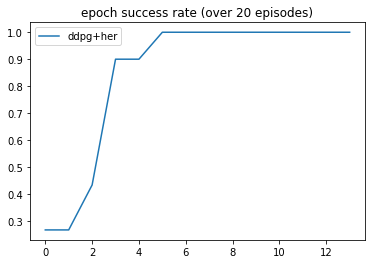

epoch 15 success rate 1.00 ep_mean_r -69.53 exploration 3.45          

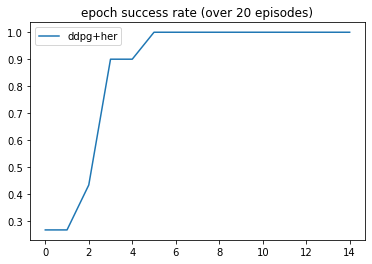

epoch 16 success rate 1.00 ep_mean_r -55.17 exploration 3.39          

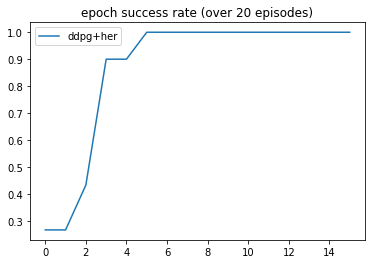

epoch 17 success rate 1.00 ep_mean_r -37.23 exploration 3.34          

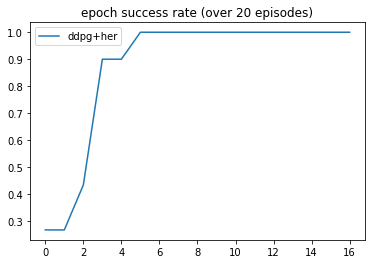

epoch 18 success rate 1.00 ep_mean_r -134.07 exploration 3.27          

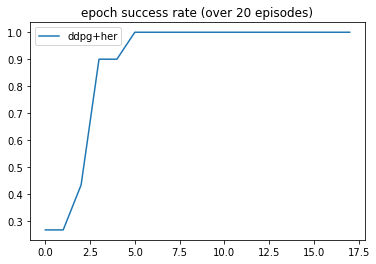

epoch 19 success rate 1.00 ep_mean_r -57.87 exploration 3.22          

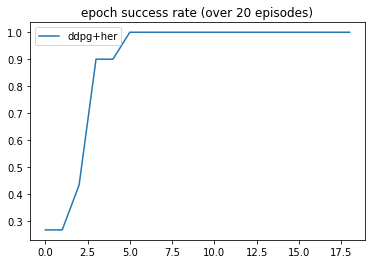

epoch 20 success rate 1.00 ep_mean_r -17.97 exploration 3.17          

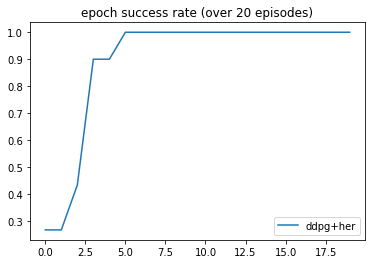

epoch 21 success rate 1.00 ep_mean_r -44.53 exploration 3.12          

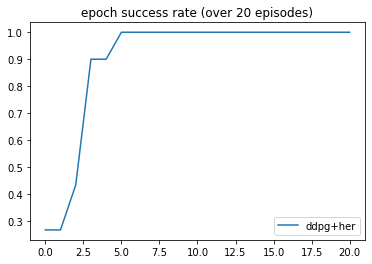

epoch 22 success rate 1.00 ep_mean_r -21.43 exploration 3.07          

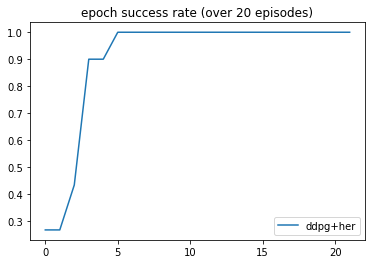

epoch 23 success rate 1.00 ep_mean_r -30.27 exploration 3.02          

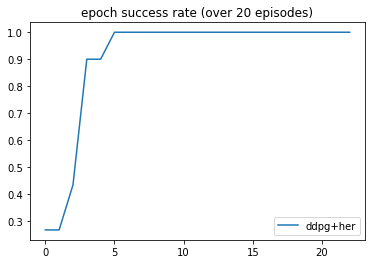

epoch 24 success rate 1.00 ep_mean_r -21.67 exploration 2.97          

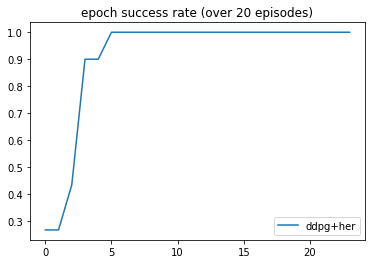

epoch 25 success rate 1.00 ep_mean_r -32.33 exploration 2.93          

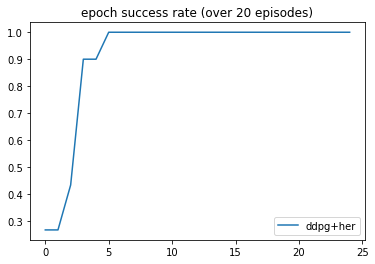

epoch 26 success rate 1.00 ep_mean_r -26.10 exploration 2.88          

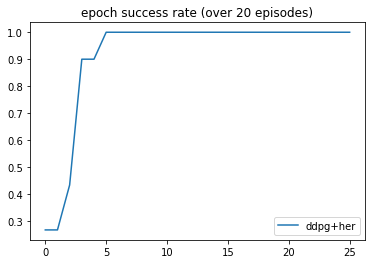

epoch 27 success rate 1.00 ep_mean_r -23.30 exploration 2.84          

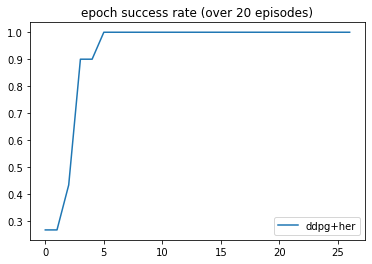

epoch 28 success rate 1.00 ep_mean_r -16.87 exploration 2.79          

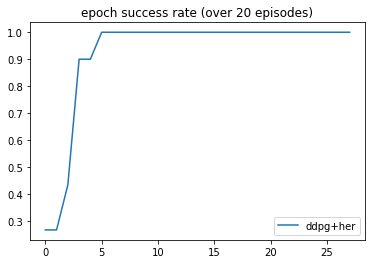

epoch 29 success rate 1.00 ep_mean_r -26.70 exploration 2.75          

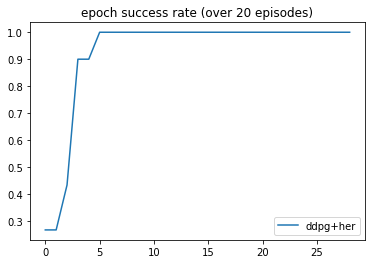

epoch 30 success rate 1.00 ep_mean_r -23.37 exploration 2.70          

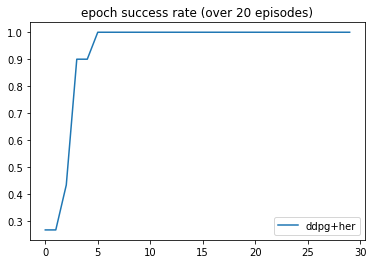

epoch 31 success rate 1.00 ep_mean_r -23.37 exploration 2.66          

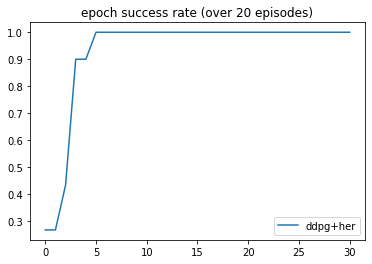

epoch 32 success rate 1.00 ep_mean_r -15.57 exploration 2.62          

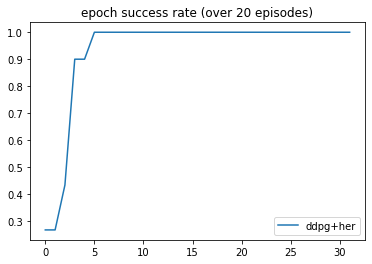

epoch 33 success rate 1.00 ep_mean_r -22.07 exploration 2.58          

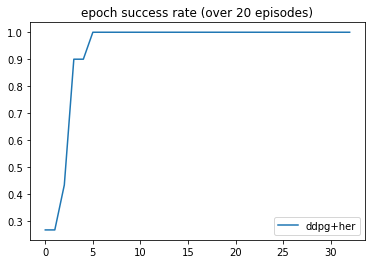

epoch 34 success rate 1.00 ep_mean_r -61.40 exploration 2.54          

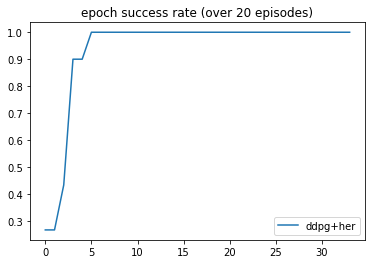

epoch 35 success rate 1.00 ep_mean_r -14.73 exploration 2.50          

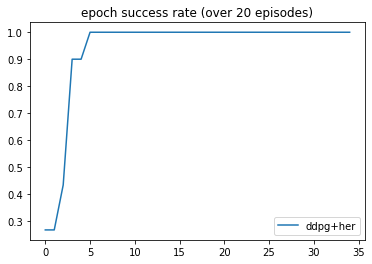

epoch 36 success rate 1.00 ep_mean_r -17.73 exploration 2.46          

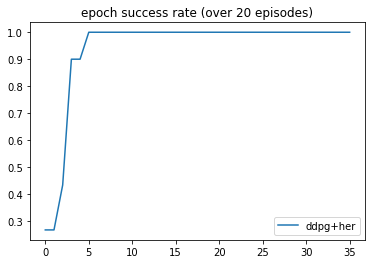

epoch 37 success rate 1.00 ep_mean_r -18.87 exploration 2.42          

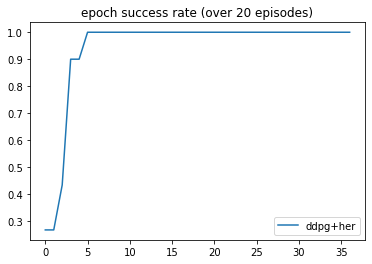

epoch 38 success rate 1.00 ep_mean_r -31.77 exploration 2.38          

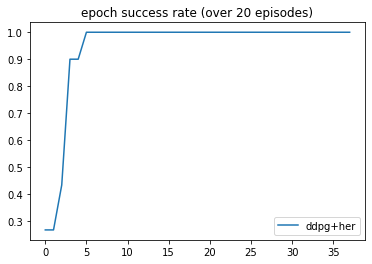

epoch 39 success rate 1.00 ep_mean_r -12.70 exploration 2.34          

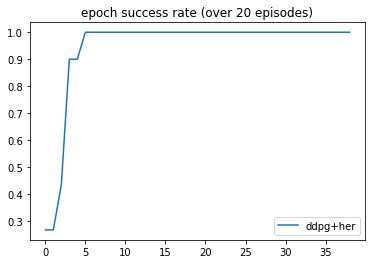

epoch 40 success rate 1.00 ep_mean_r -10.97 exploration 2.31          

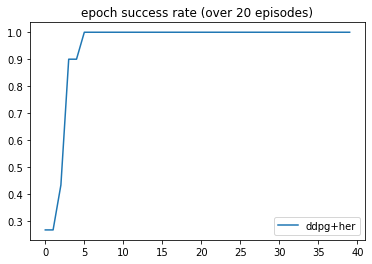

epoch 41 success rate 1.00 ep_mean_r -19.30 exploration 2.27          

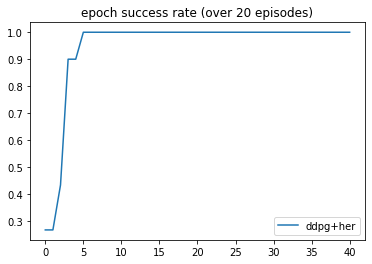

epoch 42 success rate 1.00 ep_mean_r -13.33 exploration 2.24          

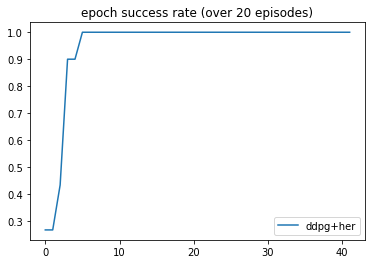

epoch 43 success rate 1.00 ep_mean_r -6.70 exploration 2.20          

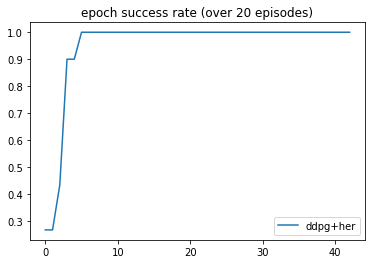

epoch 44 success rate 1.00 ep_mean_r -17.87 exploration 2.17          

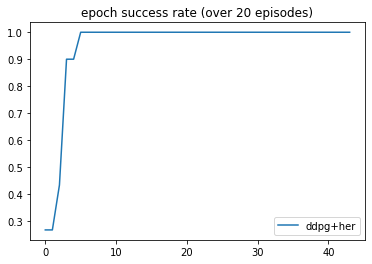

epoch 45 success rate 1.00 ep_mean_r -5.53 exploration 2.13          

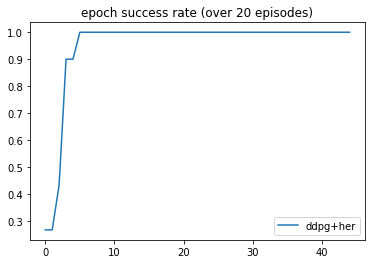

epoch 46 success rate 1.00 ep_mean_r -5.97 exploration 2.10          

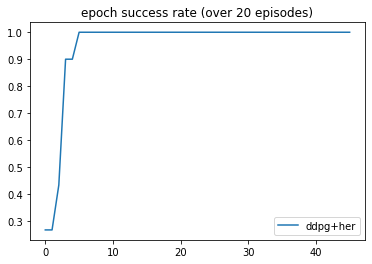

epoch 47 success rate 1.00 ep_mean_r -10.00 exploration 2.07          

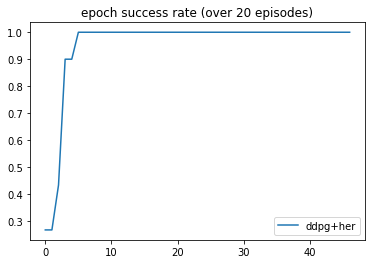

epoch 48 success rate 1.00 ep_mean_r -15.03 exploration 2.04          

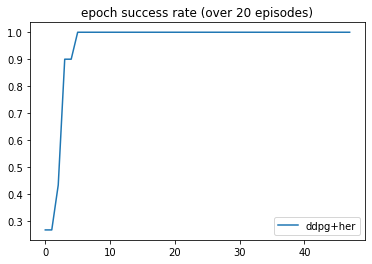

epoch 49 success rate 1.00 ep_mean_r -7.10 exploration 2.01          

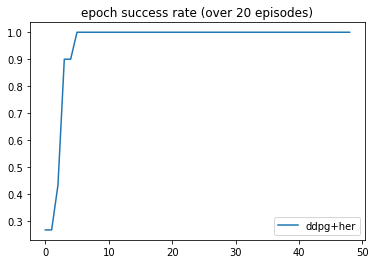

epoch 50 success rate 1.00 ep_mean_r -10.37 exploration 1.97          

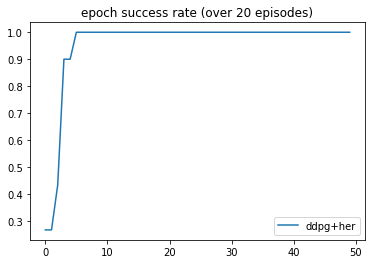

epoch 51 success rate 1.00 ep_mean_r -4.47 exploration 1.94          

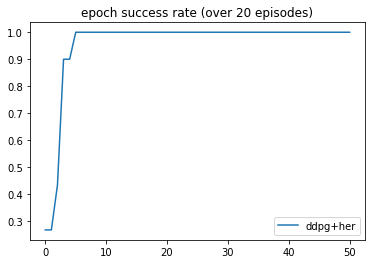

epoch 52 success rate 1.00 ep_mean_r -5.47 exploration 1.91          

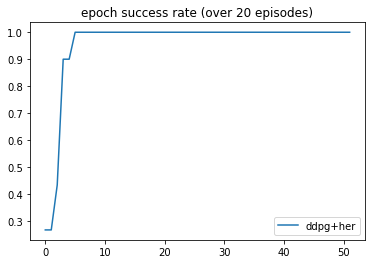

epoch 53 success rate 1.00 ep_mean_r -7.77 exploration 1.88          

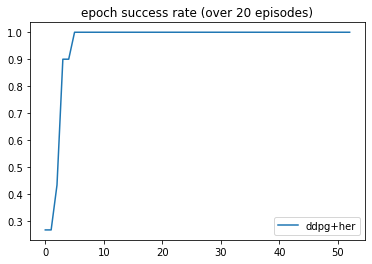

epoch 54 success rate 1.00 ep_mean_r -9.67 exploration 1.85          

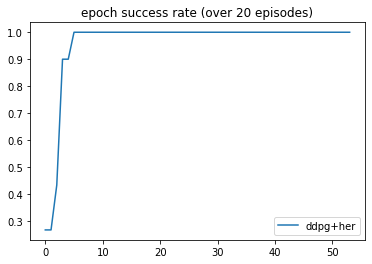

epoch 55 success rate 1.00 ep_mean_r -9.97 exploration 1.83          

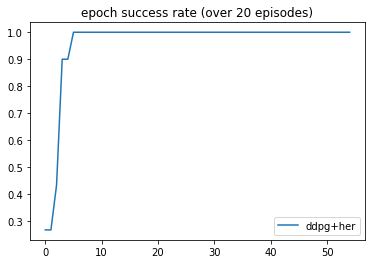

epoch 56 success rate 1.00 ep_mean_r -7.20 exploration 1.80          

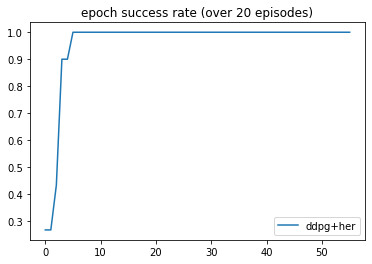

epoch 57 success rate 1.00 ep_mean_r -12.40 exploration 1.77          

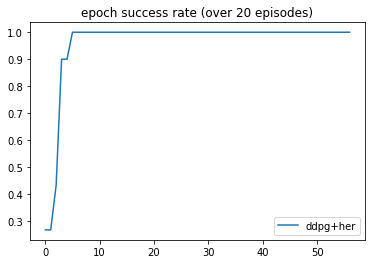

epoch 58 success rate 1.00 ep_mean_r -10.17 exploration 1.74          

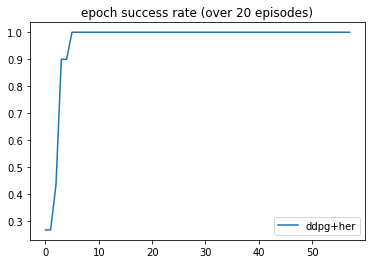

epoch 59 success rate 1.00 ep_mean_r -3.37 exploration 1.72          

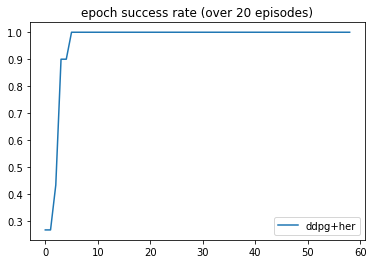

epoch 60 success rate 1.00 ep_mean_r -38.90 exploration 1.69          

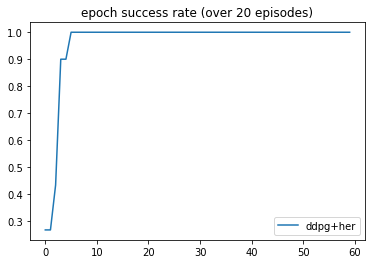

epoch 61 success rate 1.00 ep_mean_r -2.20 exploration 1.66          

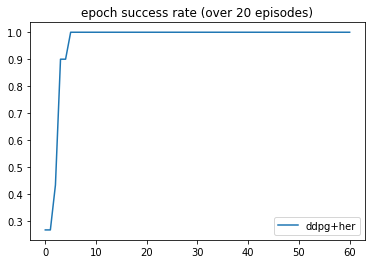

epoch 62 success rate 1.00 ep_mean_r -6.97 exploration 1.64          

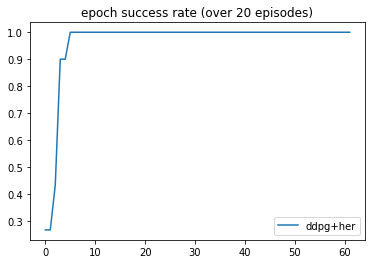

epoch 63 success rate 1.00 ep_mean_r -7.73 exploration 1.61          

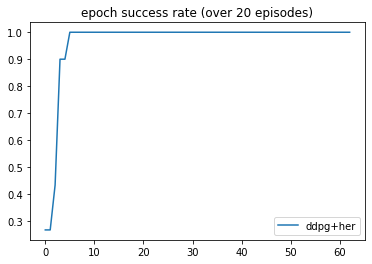

epoch 64 success rate 1.00 ep_mean_r 2.30 exploration 1.59          

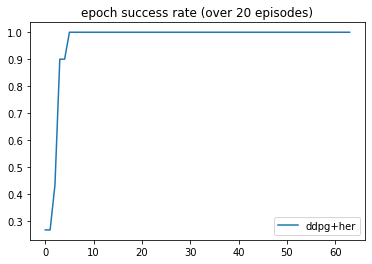

epoch 65 success rate 1.00 ep_mean_r -7.33 exploration 1.56          

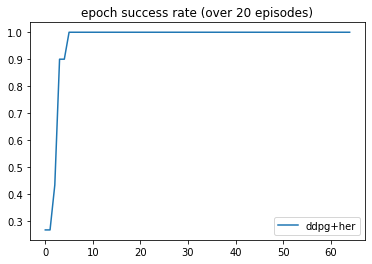

epoch 66 success rate 1.00 ep_mean_r -10.80 exploration 1.54          

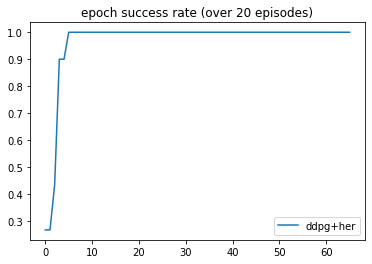

epoch 67 success rate 1.00 ep_mean_r -1.13 exploration 1.51          

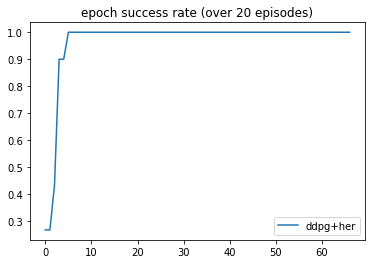

epoch 68 success rate 1.00 ep_mean_r 0.20 exploration 1.49          

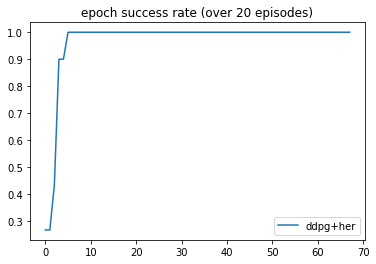

epoch 69 success rate 1.00 ep_mean_r -3.50 exploration 1.47          

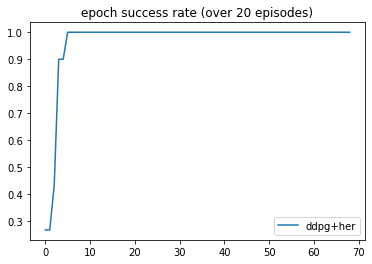

epoch 70 success rate 1.00 ep_mean_r -1.53 exploration 1.45          

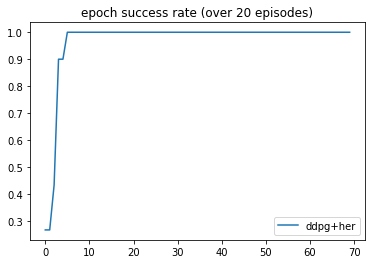

epoch 71 success rate 1.00 ep_mean_r 2.33 exploration 1.42          

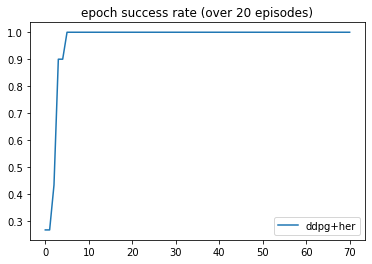

epoch 72 success rate 1.00 ep_mean_r 4.33 exploration 1.40          

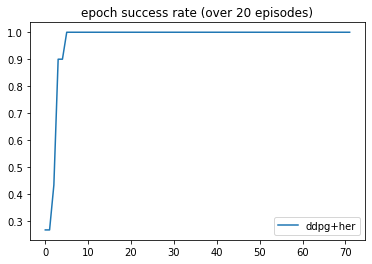

epoch 73 success rate 1.00 ep_mean_r 1.47 exploration 1.38          

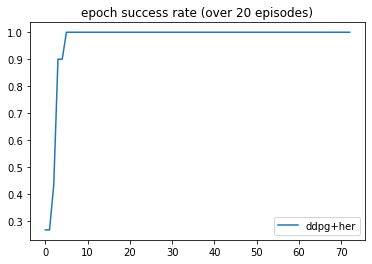

epoch 74 success rate 1.00 ep_mean_r -3.67 exploration 1.36          

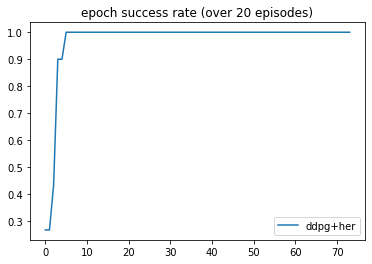

epoch 75 success rate 1.00 ep_mean_r -21.67 exploration 1.34          

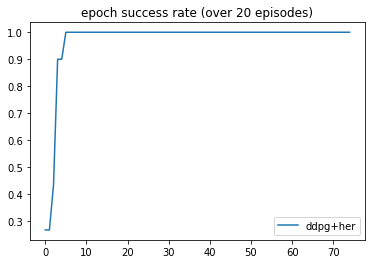

epoch 76 success rate 1.00 ep_mean_r -1.07 exploration 1.32          

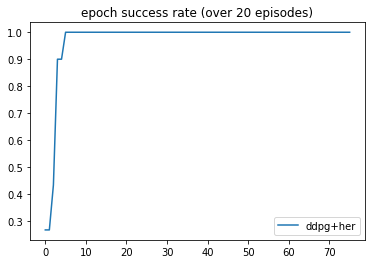

epoch 77 success rate 1.00 ep_mean_r -2.30 exploration 1.30          

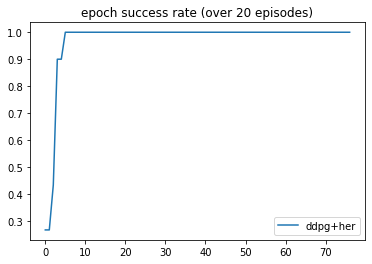

epoch 78 success rate 1.00 ep_mean_r 2.03 exploration 1.28          

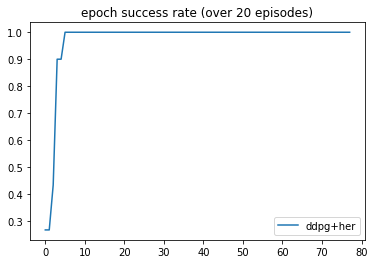

epoch 79 success rate 1.00 ep_mean_r 0.63 exploration 1.26          

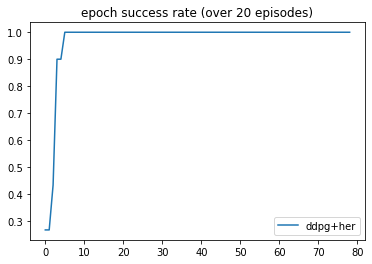

epoch 80 success rate 1.00 ep_mean_r 4.33 exploration 1.24          

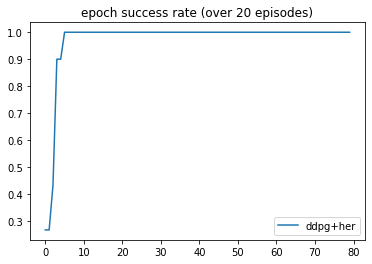

epoch 81 success rate 1.00 ep_mean_r 4.10 exploration 1.22          

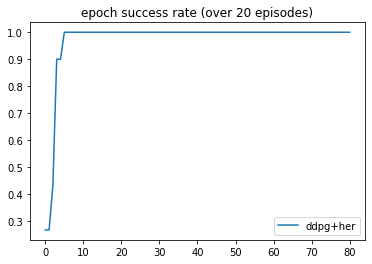

epoch 82 success rate 1.00 ep_mean_r -0.13 exploration 1.20          

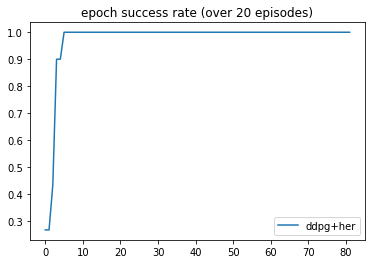

epoch 83 success rate 1.00 ep_mean_r 4.67 exploration 1.18          

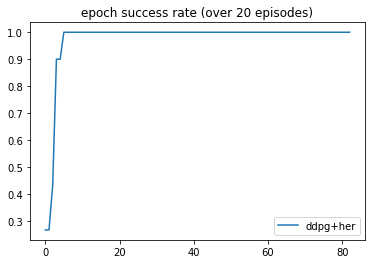

epoch 84 success rate 1.00 ep_mean_r 4.53 exploration 1.16          

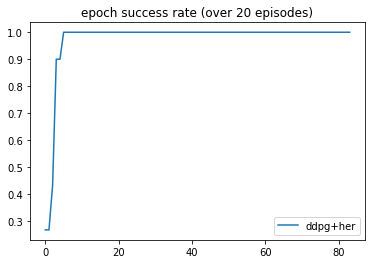

epoch 85 success rate 1.00 ep_mean_r 4.10 exploration 1.15          

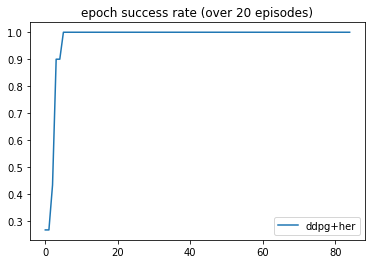

epoch 86 success rate 1.00 ep_mean_r -7.10 exploration 1.13          

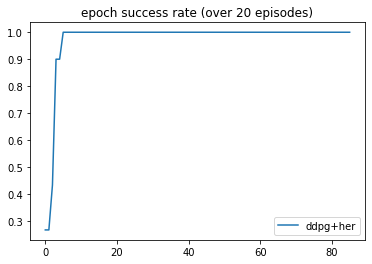

epoch 87 success rate 1.00 ep_mean_r -72.60 exploration 1.11          

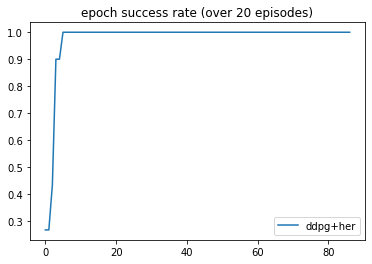

epoch 88 success rate 1.00 ep_mean_r 1.93 exploration 1.09          

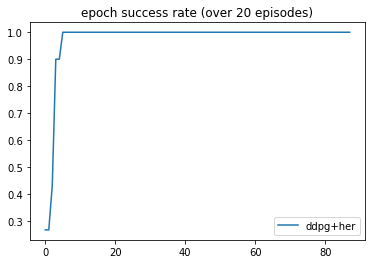

epoch 89 success rate 1.00 ep_mean_r -1.83 exploration 1.08          

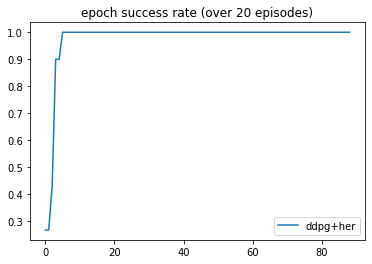

epoch 90 success rate 1.00 ep_mean_r 1.97 exploration 1.06          

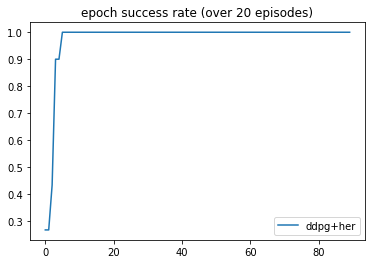

epoch 91 success rate 1.00 ep_mean_r -0.93 exploration 1.04          

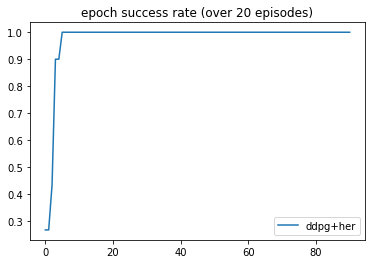

epoch 92 success rate 1.00 ep_mean_r 0.70 exploration 1.03          

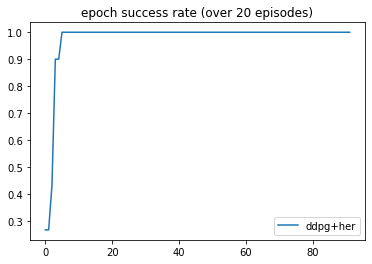

epoch 93 success rate 1.00 ep_mean_r 5.10 exploration 1.01          

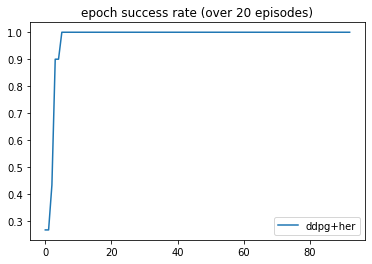

epoch 94 success rate 1.00 ep_mean_r 3.63 exploration 1.00          

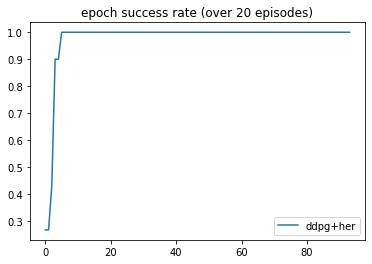

epoch 95 success rate 1.00 ep_mean_r 5.20 exploration 0.98          

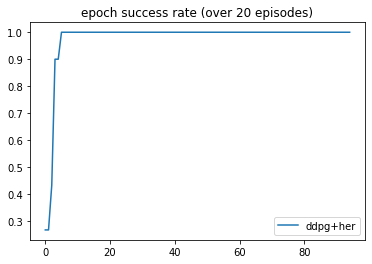

epoch 96 success rate 1.00 ep_mean_r 3.43 exploration 0.97          

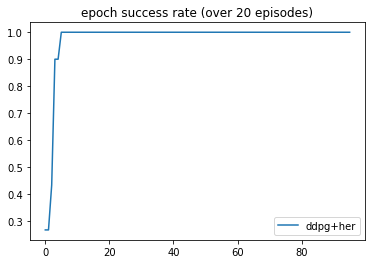

epoch 97 success rate 1.00 ep_mean_r 4.13 exploration 0.95          

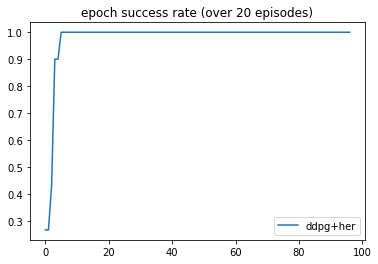

epoch 98 success rate 1.00 ep_mean_r -5.30 exploration 0.94          

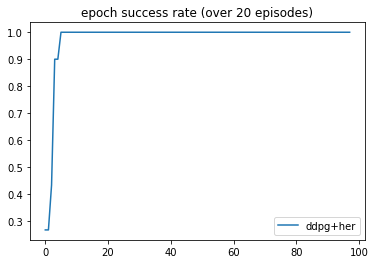

epoch 99 success rate 1.00 ep_mean_r 4.93 exploration 0.92          

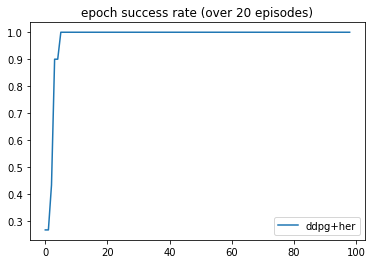

epoch 100 success rate 1.00 ep_mean_r 4.23 exploration 0.91          

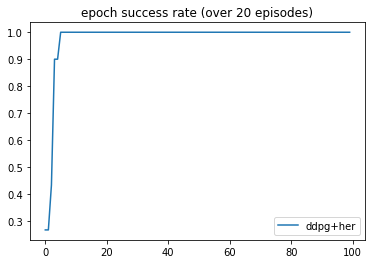

epoch 101 success rate 1.00 ep_mean_r 4.50 exploration 0.90          

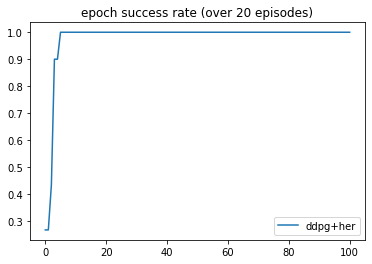

epoch 102 success rate 1.00 ep_mean_r 3.73 exploration 0.88          

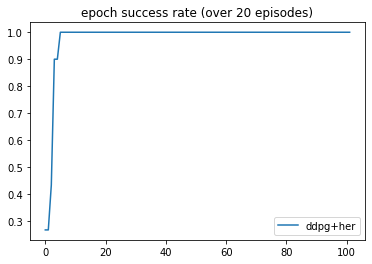

epoch 103 success rate 1.00 ep_mean_r 1.17 exploration 0.87          

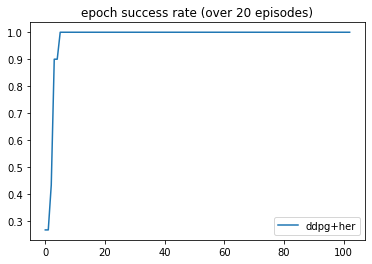

epoch 104 success rate 1.00 ep_mean_r -13.83 exploration 0.85          

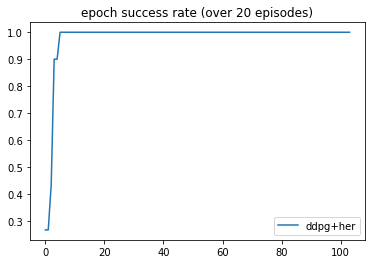

epoch 105 success rate 1.00 ep_mean_r -9.13 exploration 0.84          

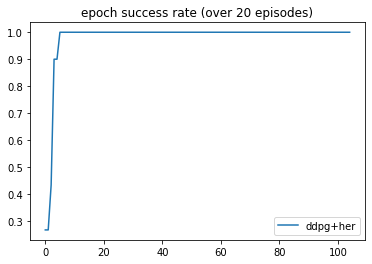

epoch 106 success rate 1.00 ep_mean_r 1.17 exploration 0.83          

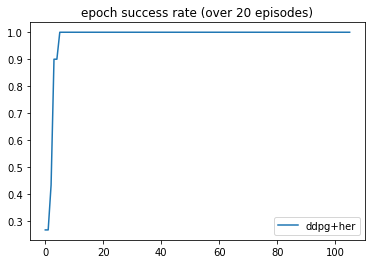

epoch 107 success rate 1.00 ep_mean_r 4.37 exploration 0.82          

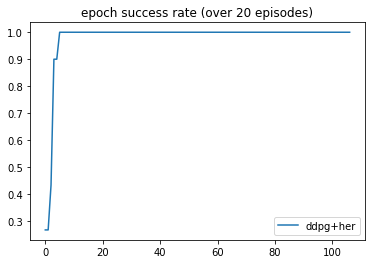

epoch 108 success rate 0.97 ep_mean_r -32.40 exploration 0.80          

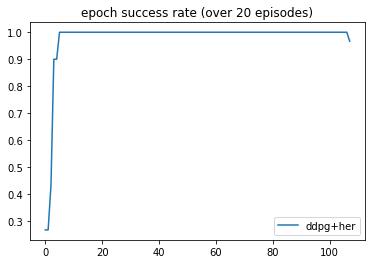

epoch 109 success rate 0.93 ep_mean_r -53.20 exploration 0.79          

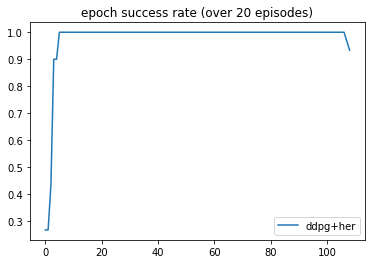

epoch 110 success rate 1.00 ep_mean_r -15.23 exploration 0.78          

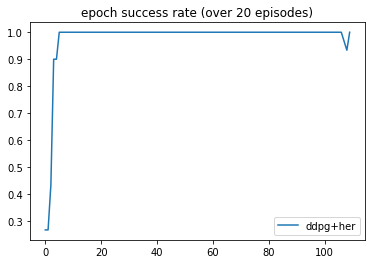

epoch 111 success rate 1.00 ep_mean_r -26.70 exploration 0.76          

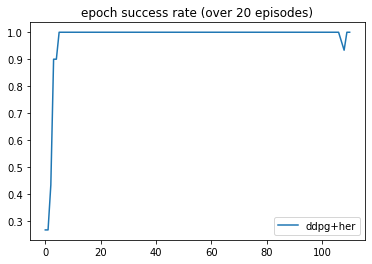

epoch 112 success rate 1.00 ep_mean_r -11.83 exploration 0.75          

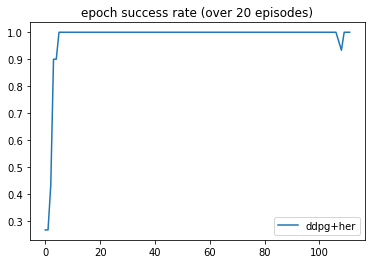

epoch 113 success rate 1.00 ep_mean_r -30.93 exploration 0.74          

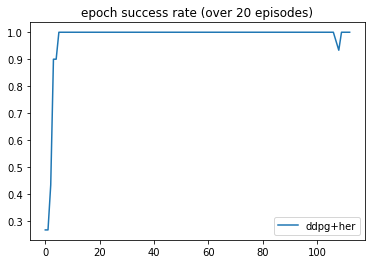

epoch 114 success rate 1.00 ep_mean_r 0.87 exploration 0.73          

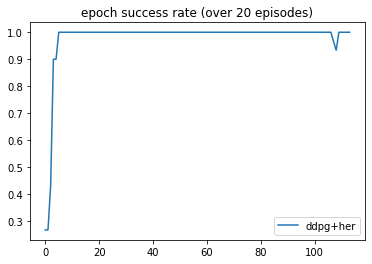

epoch 115 success rate 0.97 ep_mean_r -51.67 exploration 0.71          

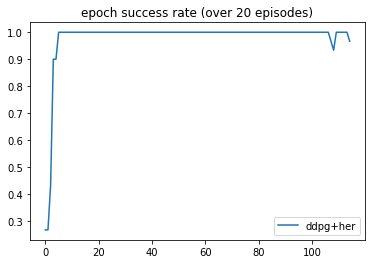

epoch 116 success rate 1.00 ep_mean_r 2.53 exploration 0.70          

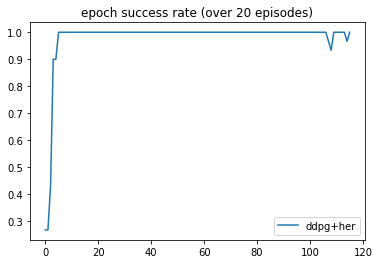

epoch 117 success rate 1.00 ep_mean_r -113.57 exploration 0.69          

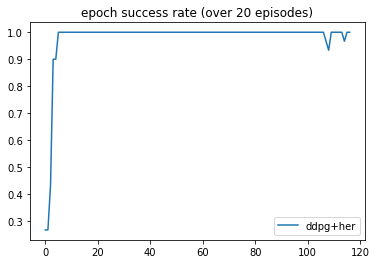

epoch 118 success rate 1.00 ep_mean_r -28.27 exploration 0.68          

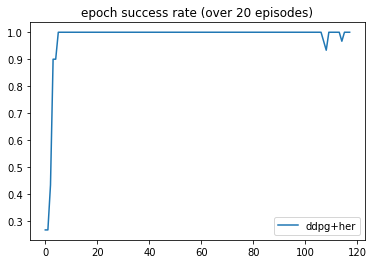

epoch 119 success rate 1.00 ep_mean_r 4.17 exploration 0.67          

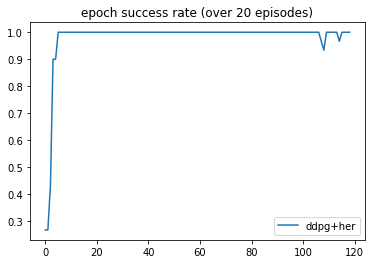

epoch 120 success rate 1.00 ep_mean_r -37.63 exploration 0.66          

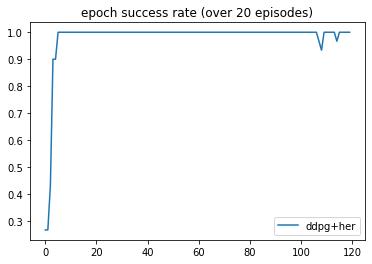

epoch 121 success rate 1.00 ep_mean_r 0.47 exploration 0.65          

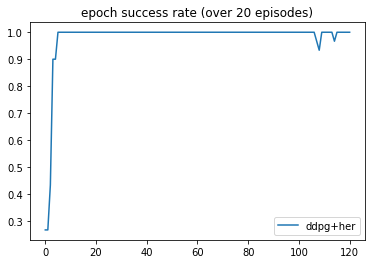

epoch 122 success rate 1.00 ep_mean_r -30.43 exploration 0.64          

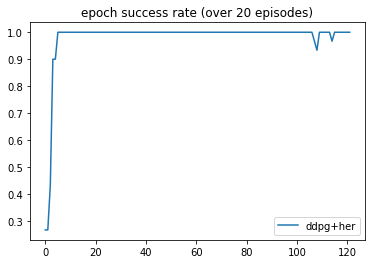

epoch 123 success rate 1.00 ep_mean_r -76.50 exploration 0.63          

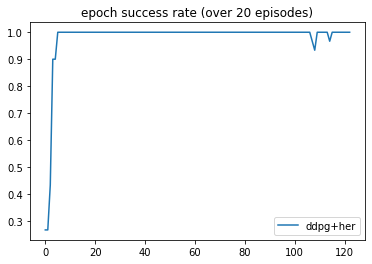

epoch 124 success rate 1.00 ep_mean_r -2.90 exploration 0.62          

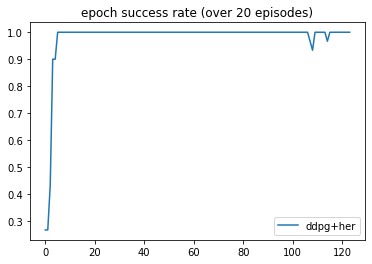

epoch 125 success rate 1.00 ep_mean_r -15.83 exploration 0.61          

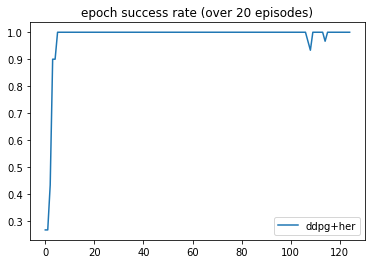

Training time : 994.08 s


In [9]:
#set_global_determinism(seed=SEED)
#env.rng = np.random.default_rng(seed=SEED)
use_her = True # use hindsight experience replay or not
num_epochs = 125 #100
num_episodes = 30 #20 # number of episodes over which success rate is computed
episode_length = 600 #500
optimization_steps = 40
K = 8 # number of random future states

a_losses = []
c_losses = []
ep_mean_r = []
success_rate = []

ep_experience = Episode_experience()
ep_experience_her = Episode_experience()

start = time.process_time()
total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        
        env.reset()
        brain_name = list(env.behavior_specs)[0]
        brain = env.behavior_specs[brain_name]
        decision_steps, terminal_steps = env.get_steps(brain_name)
        
        state = decision_steps.obs[0][0][3:]
        goal = decision_steps.obs[0][0][:3]
        
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)
            
            #print("action ",action) # -- [ 1.         -0.81721041 -1.          1.        ]
            #print("env_action.continuous ", env_action.continuous) # -- [[-0.739338 -0.739338 -0.739338 -0.739338]]
            
            env_action = brain.action_spec.random_action(len(decision_steps))
            for j in range(len(action)):
                env_action.continuous[0][j] = action[j]
            
            env.set_actions(brain_name, env_action)
            env.step()
            decision_steps, terminal_steps = env.get_steps(brain_name)
            
            for agent_id_decisions in decision_steps:
                next_state = decision_steps.obs[0][0][3:]
            for agent_id_terminated in terminal_steps:
                next_state = terminal_steps.obs[0][0][3:]
            
            for agent_id_decisions in decision_steps:
                reward = decision_steps.reward[0]
            for agent_id_terminated in terminal_steps:
                reward = terminal_steps.reward[0]
            
            dones = terminal_steps.interrupted
            done=False
            if (len(dones) > 0):
                done = True
            else:
                done=False         
            
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                if use_her: # The strategy can be changed here
                    for t in range(len(ep_experience.memory)):
                        for _ in range(K):
                            future = np.random.randint(t, len(ep_experience.memory))
                            goal_ = ep_experience.memory[future][3][3:6] # next_state of future
                            state_ = ep_experience.memory[t][0]
                            action_ = ep_experience.memory[t][1]
                            next_state_ = ep_experience.memory[t][3]
                            done_, reward_ = reward_func(next_state_, goal_)
                            ep_experience_her.add(state_, action_, reward_, next_state_, done_, goal_)
                    agent.remember(ep_experience_her)
                    ep_experience_her.clear()
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses += [a_loss]
                c_losses += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate.append(successes/num_episodes)
    ep_mean_r.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate[-1], "ep_mean_r %.2f"%ep_mean_r[-1], 'exploration %.2f'%variance, end=' '*10)

    plt.plot(success_rate, label="ddpg+her")
    plt.legend()
    plt.title("epoch success rate (over 20 episodes)")
    plt.show()

print("Training time : %.2f"%(time.process_time()-start), "s")

In [10]:
agent.saver.save(agent.sess, "model/her_rigid_table.ckpt");

## Without HER

In [11]:
agent = DDPGAgent(state_size= state_size - 3, action_size=action_size, goal_size=3, action_high=10,
                  action_low=-10, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

epoch 1 success rate 0.13 ep_mean_r -1548.70 exploration 4.78          

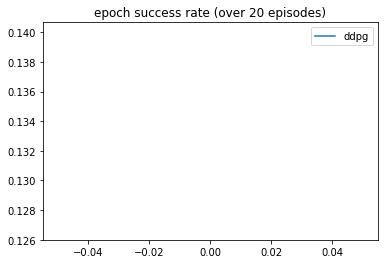

epoch 2 success rate 0.27 ep_mean_r -673.77 exploration 4.59          

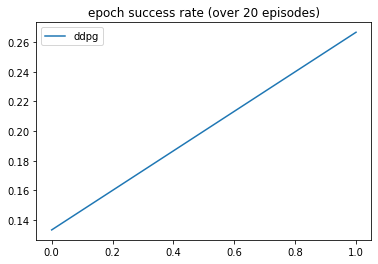

epoch 3 success rate 0.13 ep_mean_r -975.13 exploration 4.39          

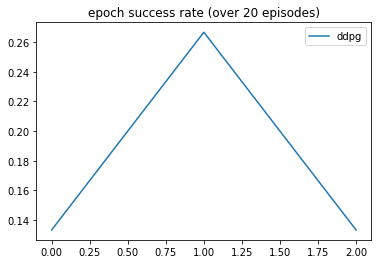

epoch 4 success rate 0.40 ep_mean_r -963.27 exploration 4.22          

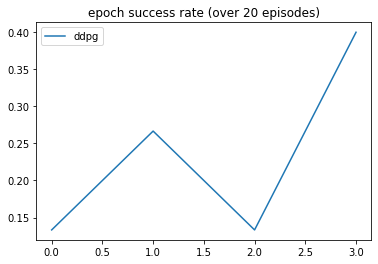

epoch 5 success rate 0.30 ep_mean_r -1274.77 exploration 4.05          

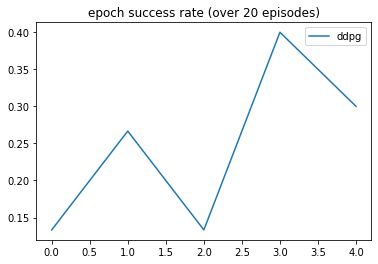

epoch 6 success rate 0.30 ep_mean_r -797.53 exploration 3.88          

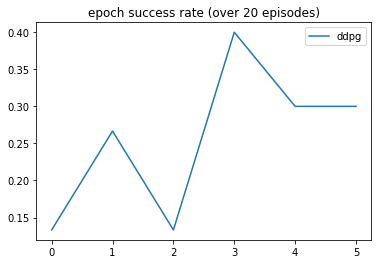

epoch 7 success rate 0.47 ep_mean_r -715.27 exploration 3.74          

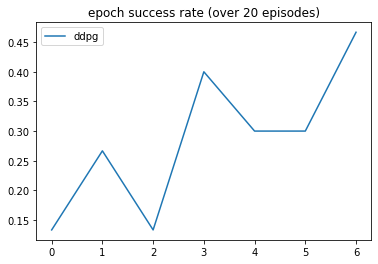

epoch 8 success rate 0.67 ep_mean_r -1024.33 exploration 3.61          

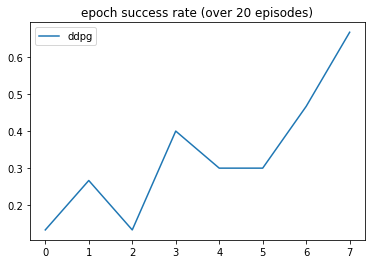

epoch 9 success rate 0.67 ep_mean_r -834.17 exploration 3.49          

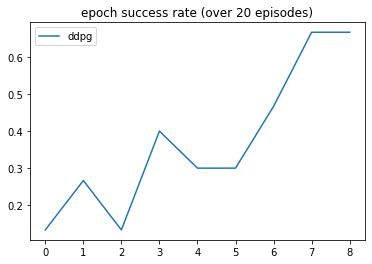

epoch 10 success rate 0.73 ep_mean_r -1038.87 exploration 3.37          

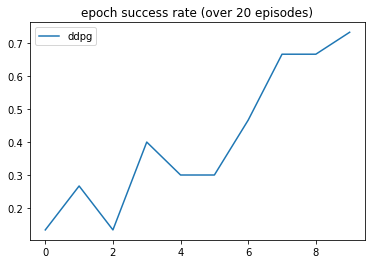

epoch 11 success rate 0.80 ep_mean_r -779.60 exploration 3.28          

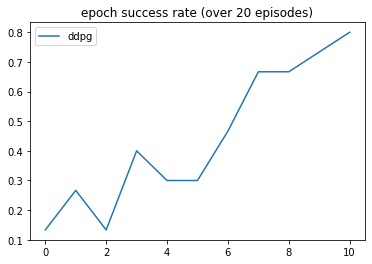

epoch 12 success rate 0.90 ep_mean_r -492.77 exploration 3.19          

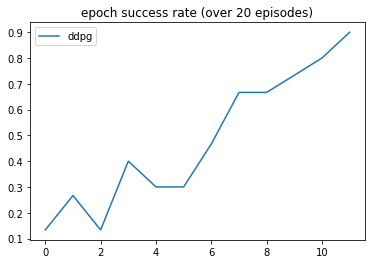

epoch 13 success rate 0.90 ep_mean_r -675.77 exploration 3.10          

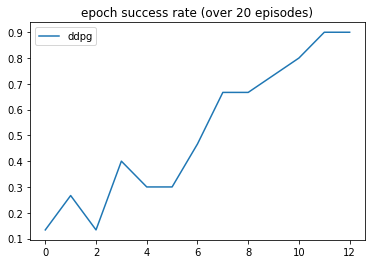

epoch 14 success rate 0.97 ep_mean_r -362.47 exploration 3.04          

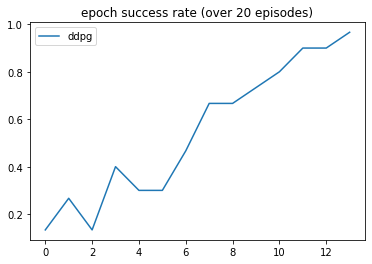

epoch 15 success rate 0.97 ep_mean_r -230.80 exploration 2.98          

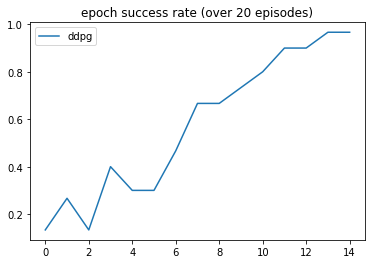

epoch 16 success rate 1.00 ep_mean_r -111.80 exploration 2.93          

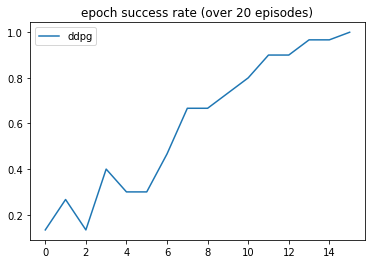

epoch 17 success rate 1.00 ep_mean_r -124.13 exploration 2.88          

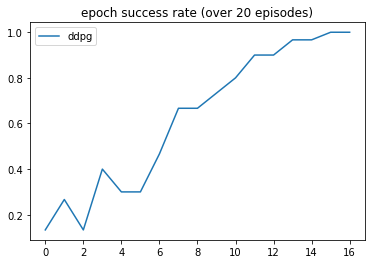

epoch 18 success rate 0.97 ep_mean_r -179.13 exploration 2.82          

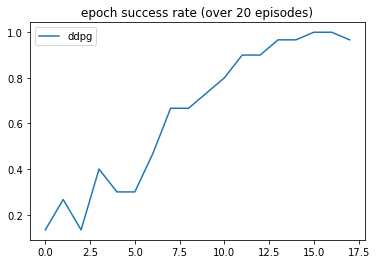

epoch 19 success rate 1.00 ep_mean_r -199.73 exploration 2.77          

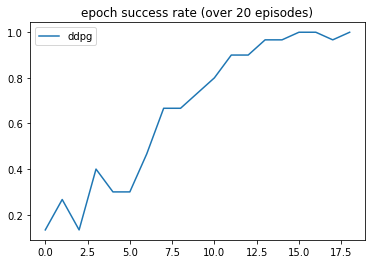

epoch 20 success rate 0.97 ep_mean_r -143.37 exploration 2.72          

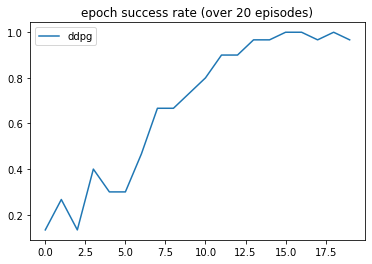

epoch 21 success rate 1.00 ep_mean_r -45.93 exploration 2.68          

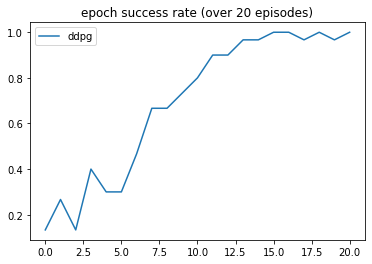

epoch 22 success rate 1.00 ep_mean_r -58.07 exploration 2.63          

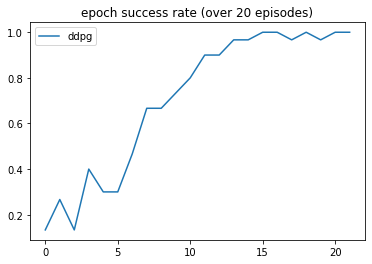

epoch 23 success rate 1.00 ep_mean_r -35.27 exploration 2.59          

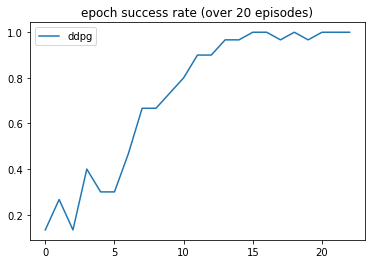

epoch 24 success rate 1.00 ep_mean_r -57.13 exploration 2.55          

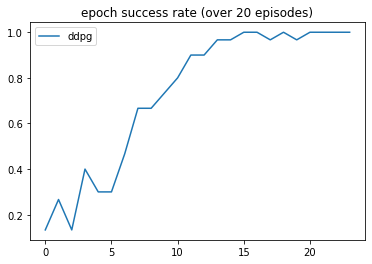

epoch 25 success rate 1.00 ep_mean_r -38.13 exploration 2.51          

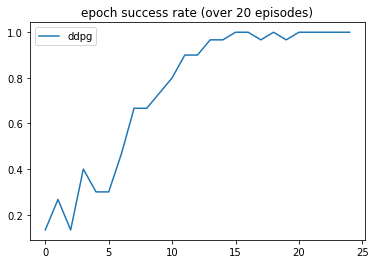

epoch 26 success rate 1.00 ep_mean_r -24.03 exploration 2.47          

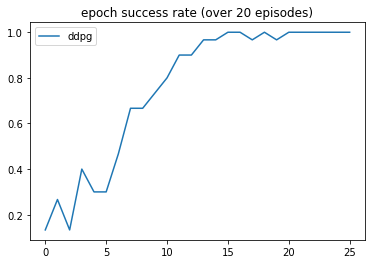

epoch 27 success rate 1.00 ep_mean_r -22.77 exploration 2.43          

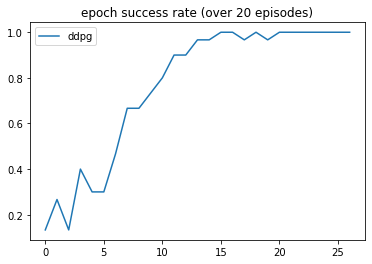

epoch 28 success rate 1.00 ep_mean_r -30.63 exploration 2.39          

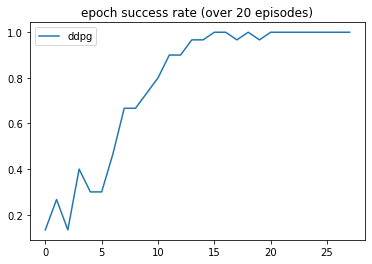

epoch 29 success rate 1.00 ep_mean_r -20.17 exploration 2.36          

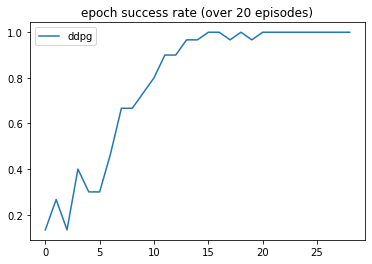

epoch 30 success rate 1.00 ep_mean_r -20.37 exploration 2.32          

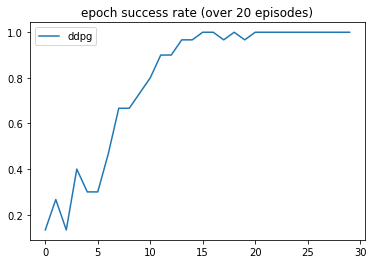

epoch 31 success rate 1.00 ep_mean_r -23.13 exploration 2.28          

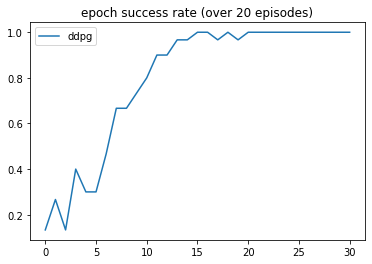

epoch 32 success rate 1.00 ep_mean_r -28.93 exploration 2.25          

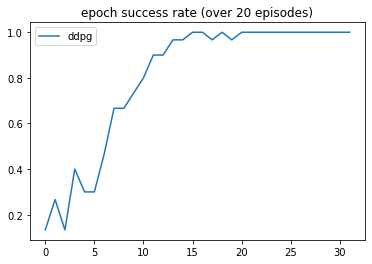

epoch 33 success rate 1.00 ep_mean_r -17.50 exploration 2.21          

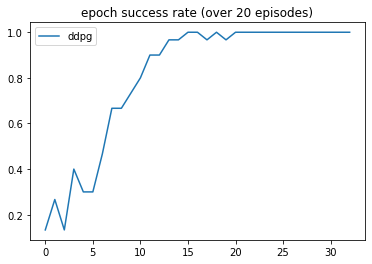

epoch 34 success rate 1.00 ep_mean_r -23.40 exploration 2.18          

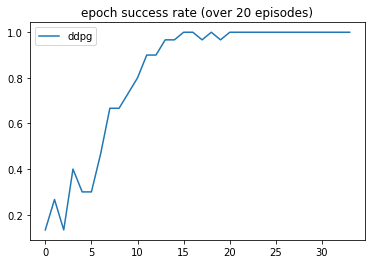

epoch 35 success rate 1.00 ep_mean_r -4.63 exploration 2.15          

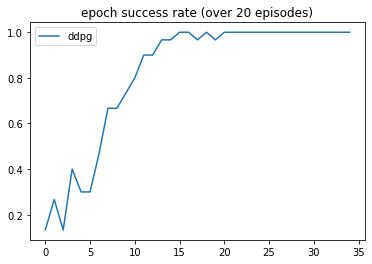

epoch 36 success rate 1.00 ep_mean_r -49.03 exploration 2.11          

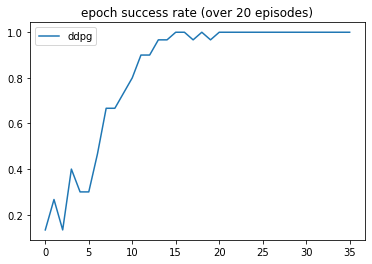

epoch 37 success rate 1.00 ep_mean_r -20.53 exploration 2.08          

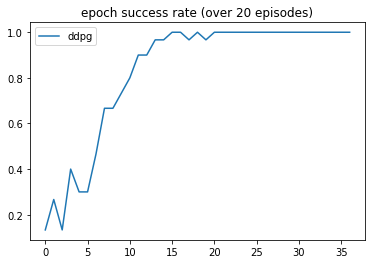

epoch 38 success rate 1.00 ep_mean_r -10.33 exploration 2.05          

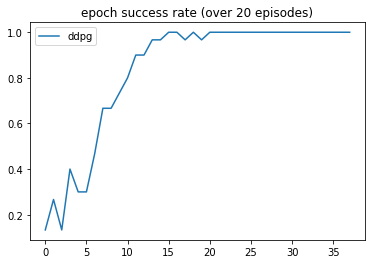

epoch 39 success rate 1.00 ep_mean_r -12.10 exploration 2.02          

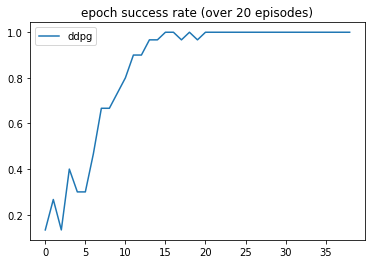

epoch 40 success rate 1.00 ep_mean_r -13.63 exploration 1.98          

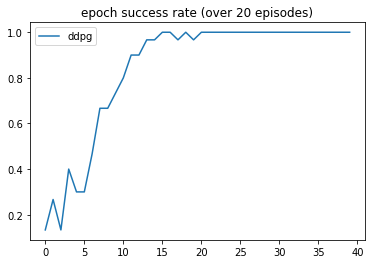

epoch 41 success rate 1.00 ep_mean_r -5.77 exploration 1.95          

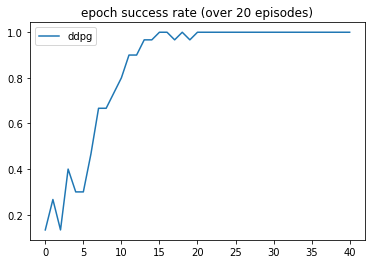

epoch 42 success rate 1.00 ep_mean_r -6.80 exploration 1.92          

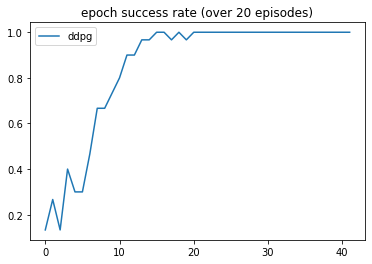

epoch 43 success rate 1.00 ep_mean_r -0.53 exploration 1.89          

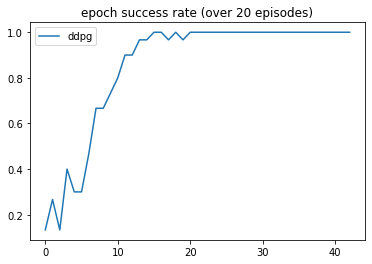

epoch 44 success rate 1.00 ep_mean_r -7.70 exploration 1.87          

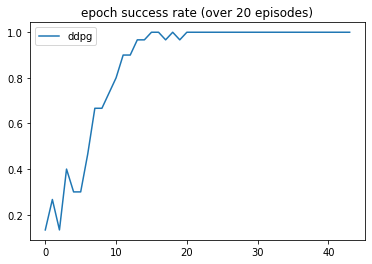

epoch 45 success rate 1.00 ep_mean_r -3.60 exploration 1.84          

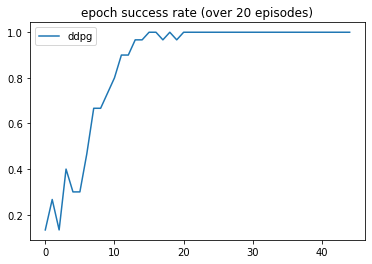

epoch 46 success rate 1.00 ep_mean_r 2.17 exploration 1.81          

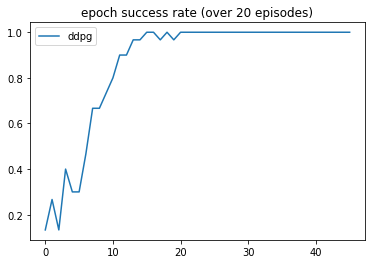

epoch 47 success rate 1.00 ep_mean_r -6.47 exploration 1.78          

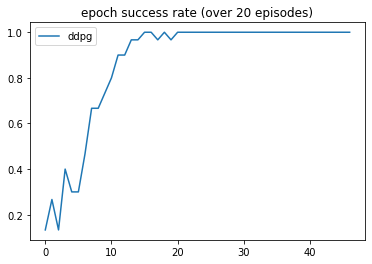

epoch 48 success rate 1.00 ep_mean_r -2.33 exploration 1.75          

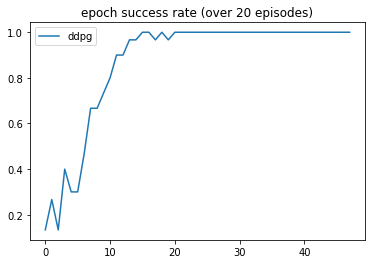

epoch 49 success rate 1.00 ep_mean_r -4.27 exploration 1.73          

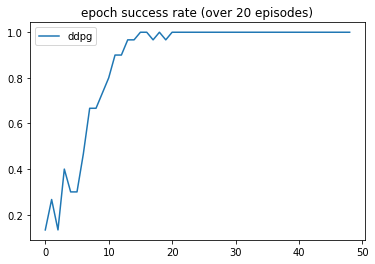

epoch 50 success rate 1.00 ep_mean_r -1.63 exploration 1.70          

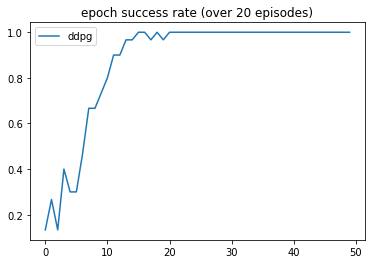

epoch 51 success rate 1.00 ep_mean_r 0.50 exploration 1.67          

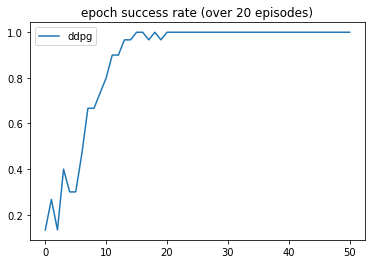

epoch 52 success rate 1.00 ep_mean_r -2.10 exploration 1.65          

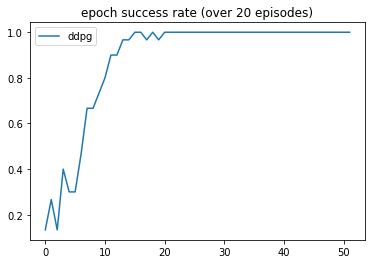

epoch 53 success rate 1.00 ep_mean_r 0.60 exploration 1.62          

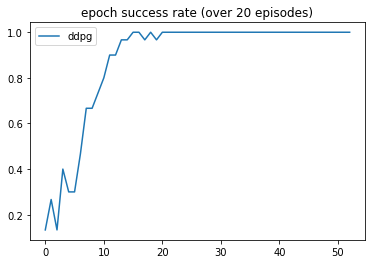

epoch 54 success rate 1.00 ep_mean_r 1.97 exploration 1.60          

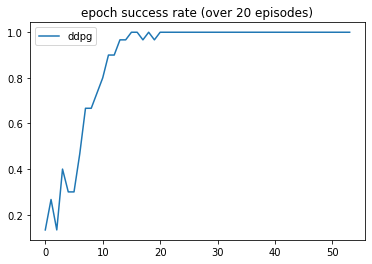

epoch 55 success rate 1.00 ep_mean_r 0.77 exploration 1.57          

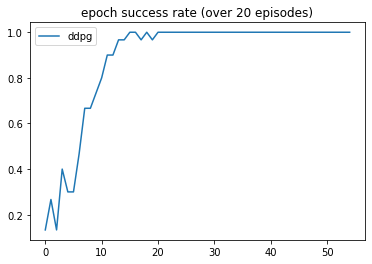

epoch 56 success rate 1.00 ep_mean_r 1.17 exploration 1.55          

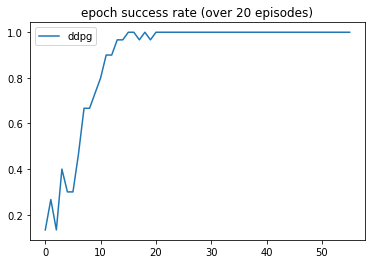

epoch 57 success rate 1.00 ep_mean_r 2.10 exploration 1.53          

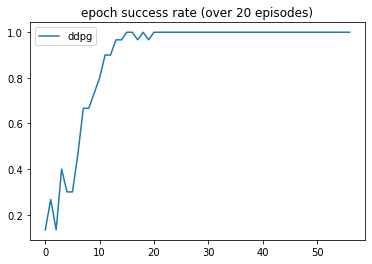

epoch 58 success rate 1.00 ep_mean_r -0.40 exploration 1.50          

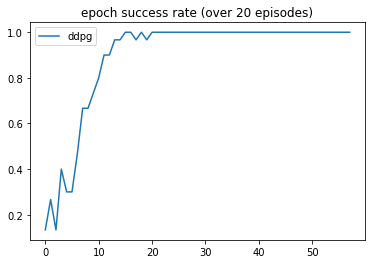

epoch 59 success rate 1.00 ep_mean_r 3.23 exploration 1.48          

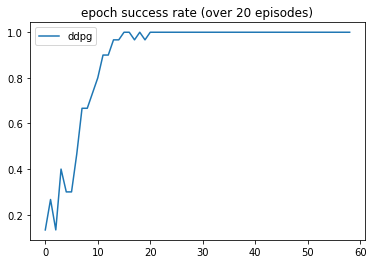

epoch 60 success rate 1.00 ep_mean_r 1.17 exploration 1.46          

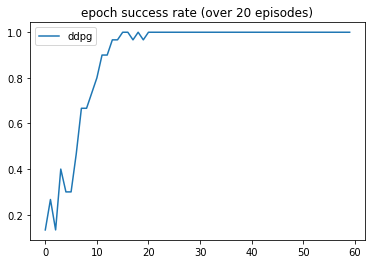

epoch 61 success rate 1.00 ep_mean_r -17.27 exploration 1.44          

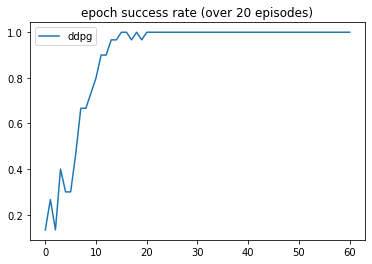

epoch 62 success rate 1.00 ep_mean_r -37.50 exploration 1.41          

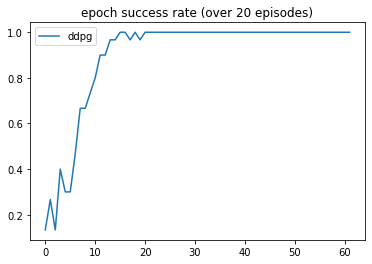

epoch 63 success rate 1.00 ep_mean_r 0.27 exploration 1.39          

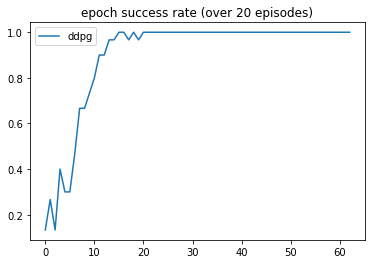

epoch 64 success rate 1.00 ep_mean_r 0.23 exploration 1.37          

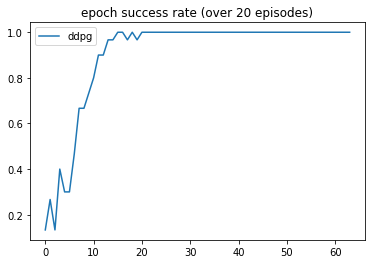

epoch 65 success rate 1.00 ep_mean_r 0.67 exploration 1.35          

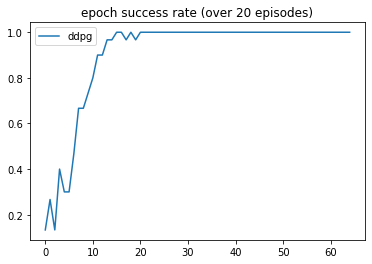

epoch 66 success rate 1.00 ep_mean_r -0.13 exploration 1.33          

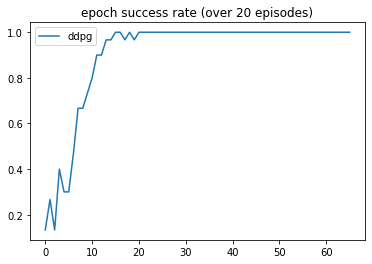

epoch 67 success rate 1.00 ep_mean_r 3.13 exploration 1.31          

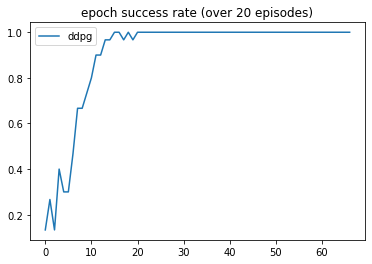

epoch 68 success rate 1.00 ep_mean_r 2.77 exploration 1.29          

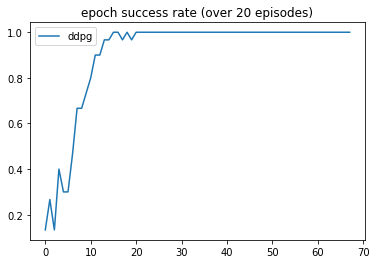

epoch 69 success rate 1.00 ep_mean_r 2.23 exploration 1.27          

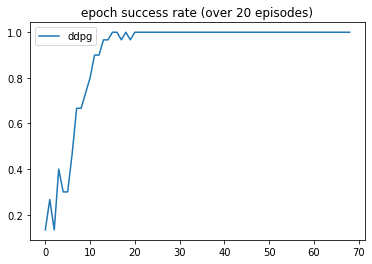

epoch 70 success rate 1.00 ep_mean_r 2.87 exploration 1.25          

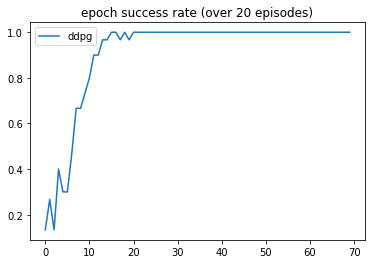

epoch 71 success rate 1.00 ep_mean_r 1.33 exploration 1.23          

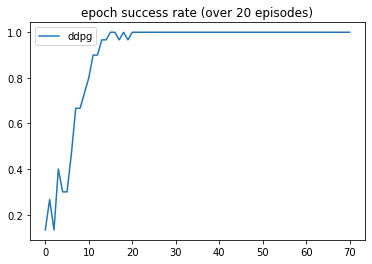

epoch 72 success rate 1.00 ep_mean_r 3.27 exploration 1.21          

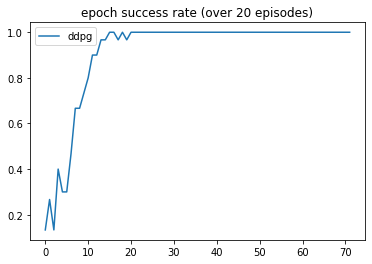

epoch 73 success rate 1.00 ep_mean_r 5.87 exploration 1.20          

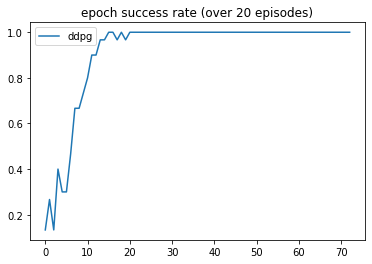

epoch 74 success rate 1.00 ep_mean_r 4.87 exploration 1.18          

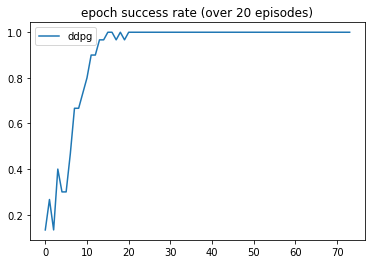

epoch 75 success rate 1.00 ep_mean_r 5.13 exploration 1.16          

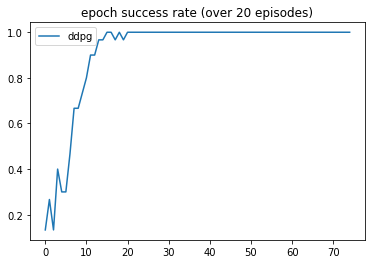

epoch 76 success rate 1.00 ep_mean_r 4.83 exploration 1.14          

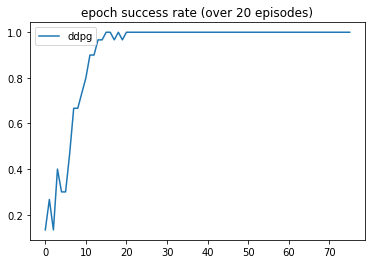

epoch 77 success rate 1.00 ep_mean_r 2.53 exploration 1.12          

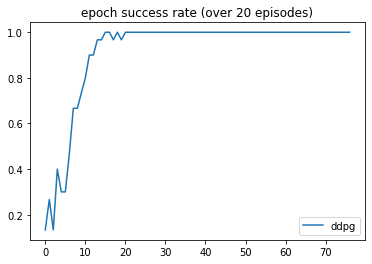

epoch 78 success rate 1.00 ep_mean_r 3.83 exploration 1.11          

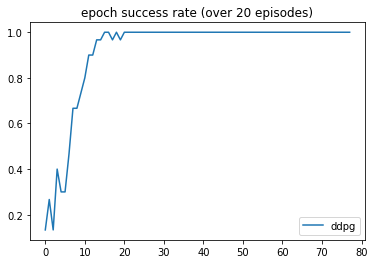

epoch 79 success rate 1.00 ep_mean_r 6.07 exploration 1.09          

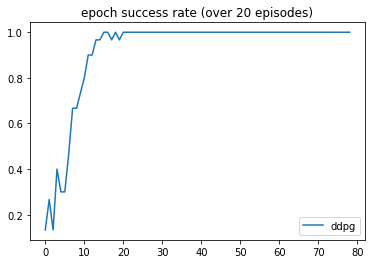

epoch 80 success rate 1.00 ep_mean_r 4.23 exploration 1.07          

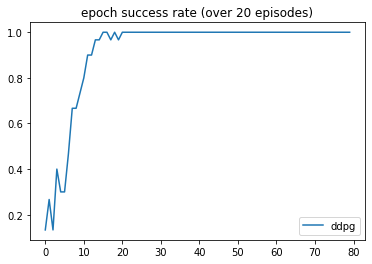

epoch 81 success rate 1.00 ep_mean_r 4.10 exploration 1.06          

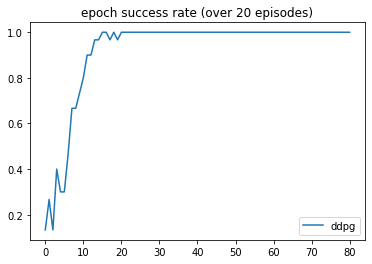

epoch 82 success rate 1.00 ep_mean_r 5.10 exploration 1.04          

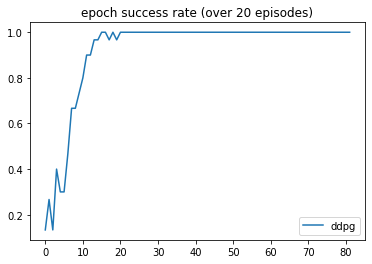

epoch 83 success rate 1.00 ep_mean_r 4.37 exploration 1.03          

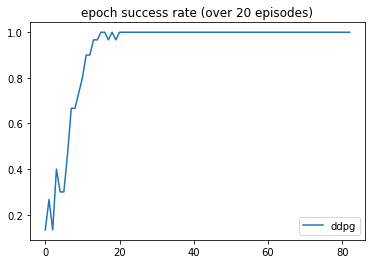

epoch 84 success rate 1.00 ep_mean_r 4.70 exploration 1.01          

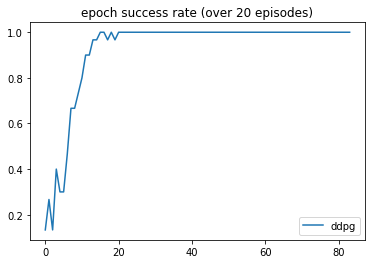

epoch 85 success rate 1.00 ep_mean_r 6.17 exploration 1.00          

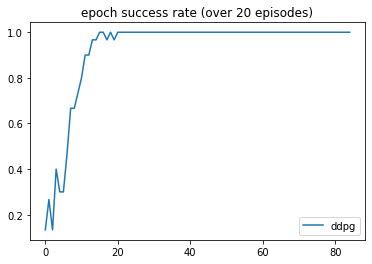

epoch 86 success rate 1.00 ep_mean_r 4.63 exploration 0.98          

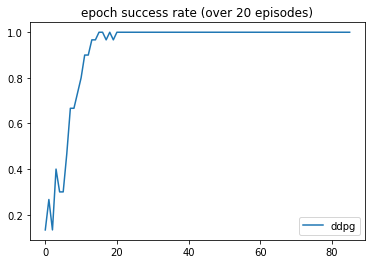

epoch 87 success rate 1.00 ep_mean_r 3.43 exploration 0.97          

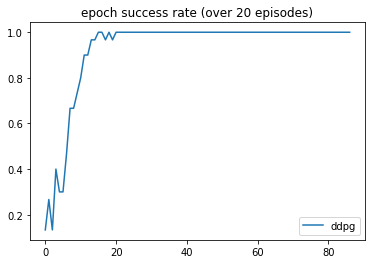

epoch 88 success rate 1.00 ep_mean_r 5.37 exploration 0.95          

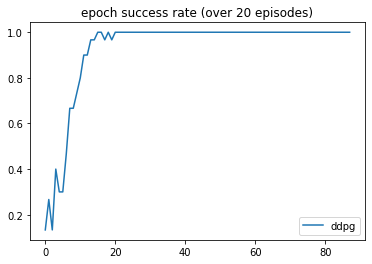

epoch 89 success rate 1.00 ep_mean_r 5.70 exploration 0.94          

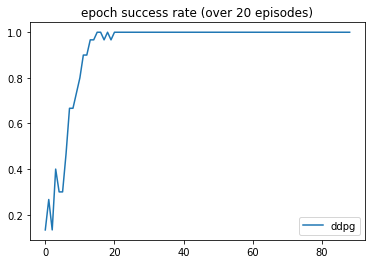

epoch 90 success rate 1.00 ep_mean_r 4.33 exploration 0.92          

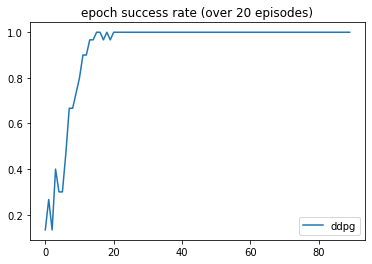

epoch 91 success rate 1.00 ep_mean_r 4.20 exploration 0.91          

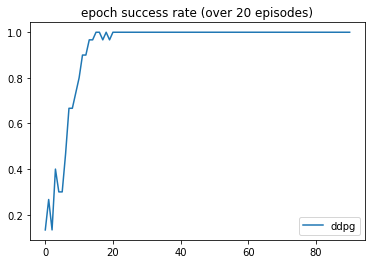

epoch 92 success rate 1.00 ep_mean_r 3.80 exploration 0.90          

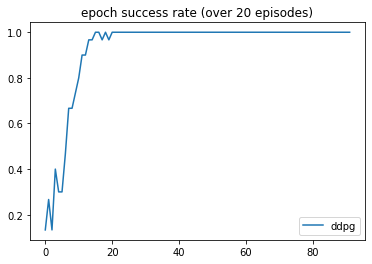

epoch 93 success rate 1.00 ep_mean_r 6.13 exploration 0.88          

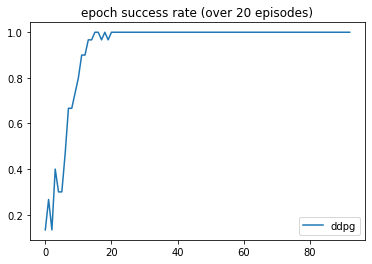

epoch 94 success rate 1.00 ep_mean_r 7.03 exploration 0.87          

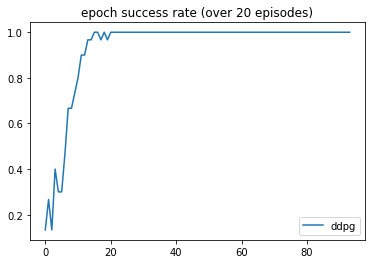

epoch 95 success rate 1.00 ep_mean_r 5.33 exploration 0.86          

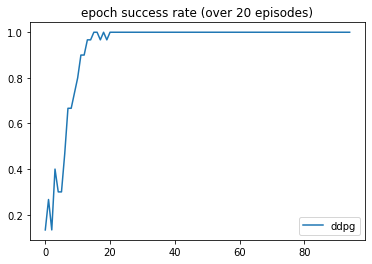

epoch 96 success rate 1.00 ep_mean_r 6.10 exploration 0.84          

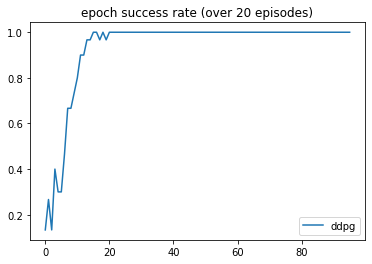

epoch 97 success rate 1.00 ep_mean_r 6.27 exploration 0.83          

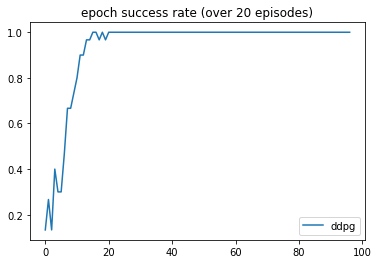

epoch 98 success rate 1.00 ep_mean_r 6.13 exploration 0.82          

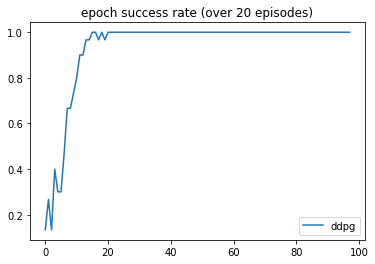

epoch 99 success rate 1.00 ep_mean_r 5.97 exploration 0.80          

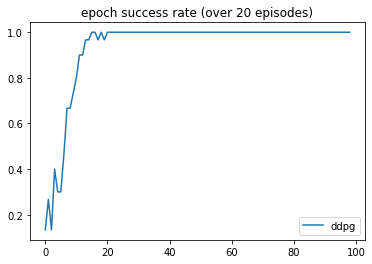

epoch 100 success rate 1.00 ep_mean_r 7.37 exploration 0.79          

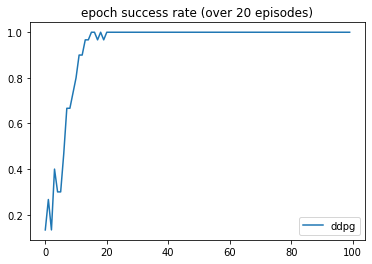

epoch 101 success rate 1.00 ep_mean_r 5.23 exploration 0.78          

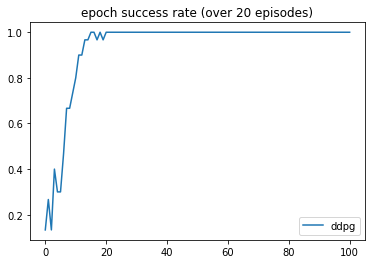

epoch 102 success rate 1.00 ep_mean_r 5.53 exploration 0.77          

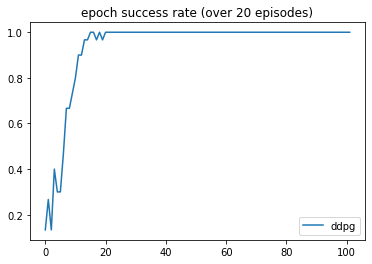

epoch 103 success rate 1.00 ep_mean_r 6.90 exploration 0.76          

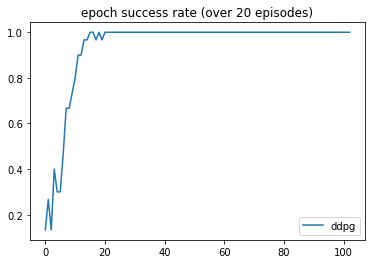

epoch 104 success rate 1.00 ep_mean_r 6.40 exploration 0.75          

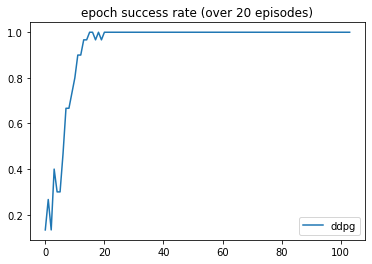

epoch 105 success rate 1.00 ep_mean_r 6.07 exploration 0.73          

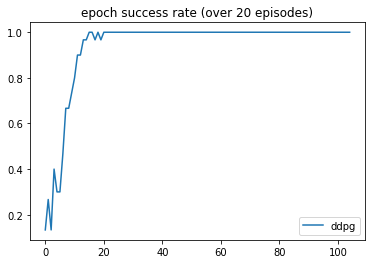

epoch 106 success rate 1.00 ep_mean_r 5.93 exploration 0.72          

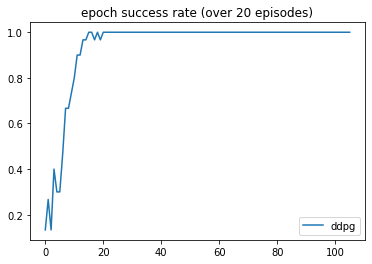

epoch 107 success rate 1.00 ep_mean_r 6.93 exploration 0.71          

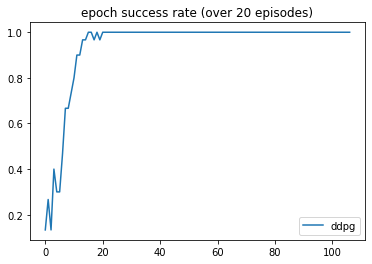

epoch 108 success rate 1.00 ep_mean_r 5.70 exploration 0.70          

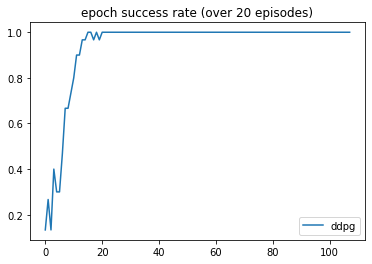

epoch 109 success rate 1.00 ep_mean_r 7.07 exploration 0.69          

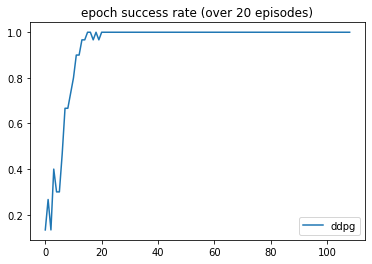

epoch 110 success rate 1.00 ep_mean_r 7.13 exploration 0.68          

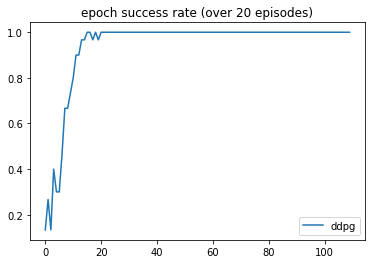

epoch 111 success rate 1.00 ep_mean_r 6.50 exploration 0.67          

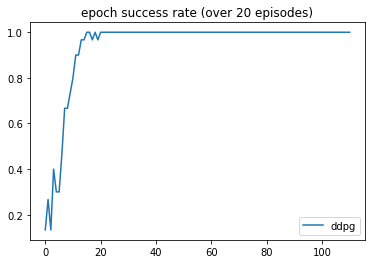

epoch 112 success rate 1.00 ep_mean_r 6.50 exploration 0.66          

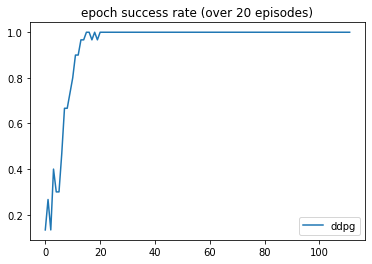

epoch 113 success rate 1.00 ep_mean_r 5.73 exploration 0.65          

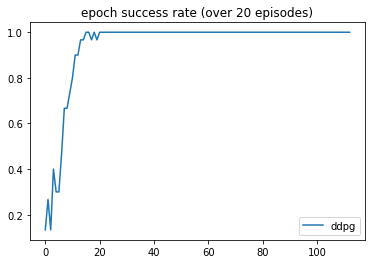

epoch 114 success rate 1.00 ep_mean_r 7.10 exploration 0.64          

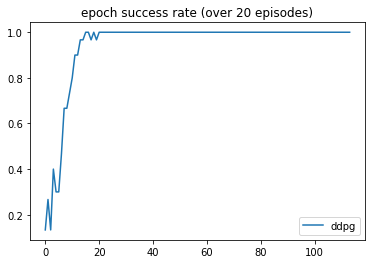

epoch 115 success rate 1.00 ep_mean_r 7.23 exploration 0.63          

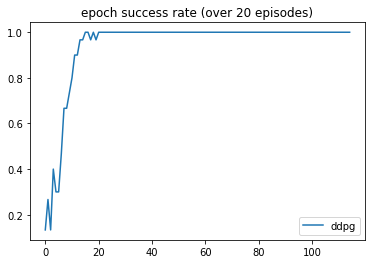

epoch 116 success rate 1.00 ep_mean_r 6.97 exploration 0.62          

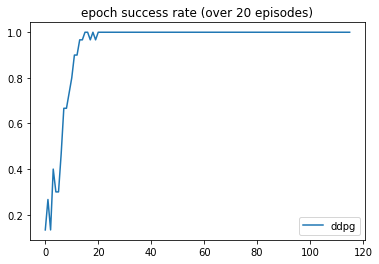

epoch 117 success rate 1.00 ep_mean_r 6.80 exploration 0.61          

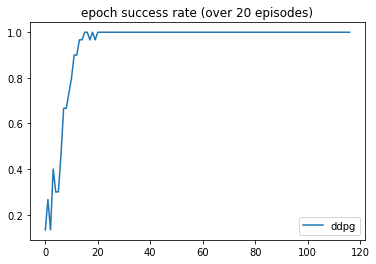

epoch 118 success rate 1.00 ep_mean_r 7.50 exploration 0.60          

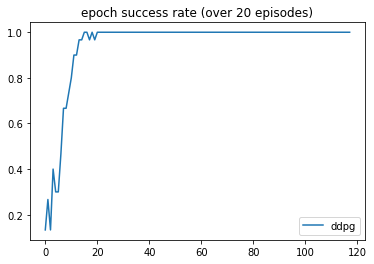

epoch 119 success rate 1.00 ep_mean_r 6.40 exploration 0.59          

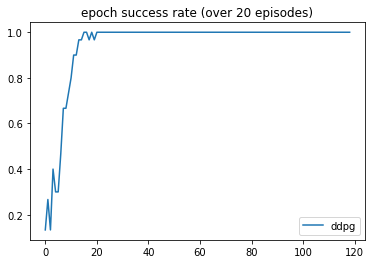

epoch 120 success rate 1.00 ep_mean_r 6.43 exploration 0.58          

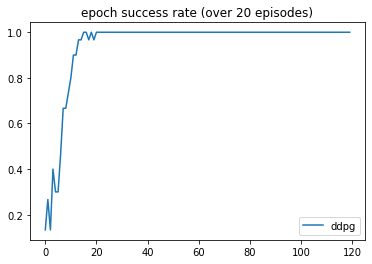

epoch 121 success rate 1.00 ep_mean_r 7.20 exploration 0.58          

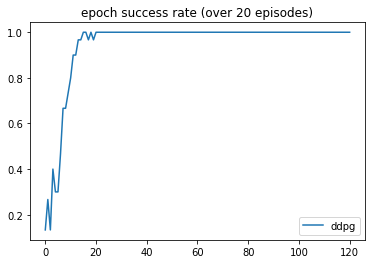

epoch 122 success rate 1.00 ep_mean_r 6.73 exploration 0.57          

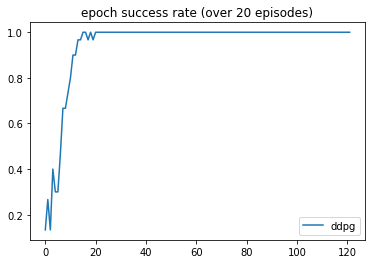

epoch 123 success rate 1.00 ep_mean_r 6.43 exploration 0.56          

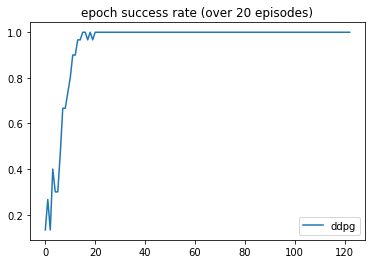

epoch 124 success rate 1.00 ep_mean_r -8.47 exploration 0.55          

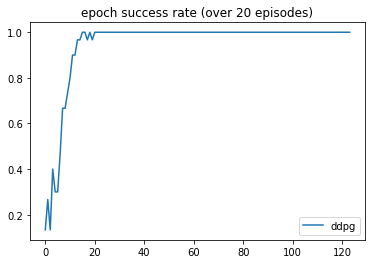

epoch 125 success rate 1.00 ep_mean_r 7.17 exploration 0.54          

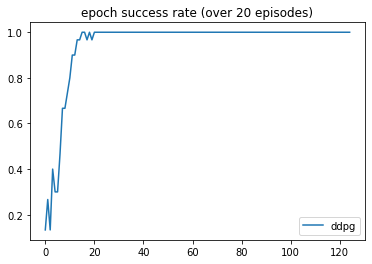

Training time : 1043.45 s


In [12]:
num_epochs = 125 #100
num_episodes = 30 #20 # number of episodes over which success rate is computed
episode_length = 600 #500
optimization_steps = 40

a_losses_without_her = []
c_losses_without_her = []
ep_mean_r_without_her = []
success_rate_without_her = []

ep_experience = Episode_experience()

start = time.process_time()

total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        env.reset()
        brain_name = list(env.behavior_specs)[0]
        brain = env.behavior_specs[brain_name]
        decision_steps, terminal_steps = env.get_steps(brain_name)
        state = decision_steps.obs[0][0][3:]
        goal = decision_steps.obs[0][0][:3]
        
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)

            env_action = brain.action_spec.random_action(len(decision_steps))
            for j in range(len(action)):
                env_action.continuous[0][j] = action[j]
            env.set_actions(brain_name, env_action)
            env.step()
            decision_steps, terminal_steps = env.get_steps(brain_name)

            for agent_id_decisions in decision_steps:
                next_state = decision_steps.obs[0][0][3:]
            for agent_id_terminated in terminal_steps:
                next_state = terminal_steps.obs[0][0][3:]
            for agent_id_decisions in decision_steps:
                reward = decision_steps.reward[0]
            for agent_id_terminated in terminal_steps:
                reward = terminal_steps.reward[0]
            
            dones = terminal_steps.interrupted
            done=False
            if (len(dones) > 0):
                done = True
            else:
                done=False         
            
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses_without_her += [a_loss]
                c_losses_without_her += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate_without_her.append(successes/num_episodes)
    ep_mean_r_without_her.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate_without_her[-1], "ep_mean_r %.2f"%ep_mean_r_without_her[-1], 'exploration %.2f'%variance, end=' '*10)

    plt.plot(success_rate_without_her, label="ddpg")
    plt.legend()
    plt.title("epoch success rate (over 20 episodes)")
    plt.show()

print("Training time : %.2f"%(time.process_time()-start), "s")

In [13]:
agent.saver.save(agent.sess, "model/without_her_rigid_table.ckpt");

## Testing

In [27]:
n_episodes = 200

test_rewards = []
agent.saver.restore(agent.sess, "model/without_her_rigid_table.ckpt")
for i_episode in range(n_episodes):
    
    env.reset()
        
    brain_name = list(env.behavior_specs)[0]
    brain = env.behavior_specs[brain_name]
    decision_steps, terminal_steps = env.get_steps(brain_name)
    state = decision_steps.obs[0][0][3:]
    goal = decision_steps.obs[0][0][:3]
    
    r = 0
    while True:
        action = agent.choose_action([state], [goal], 0)
        env_action = brain.action_spec.random_action(len(decision_steps))
        print(action)
        for j in range(len(action)):
            env_action.continuous[0][j] = action[j]
        env.set_actions(brain_name, env_action)
        env.step()
        
        print("\n state = ", state, "\n")
        
                
        decision_steps, terminal_steps = env.get_steps(brain_name)
        
        for agent_id_decisions in decision_steps:
            next_state = decision_steps.obs[0][0][3:]
        for agent_id_terminated in terminal_steps:
            next_state = terminal_steps.obs[0][0][3:]
        for agent_id_decisions in decision_steps:
            reward = decision_steps.reward[0]
        for agent_id_terminated in terminal_steps:
            reward = terminal_steps.reward[0]

        dones = terminal_steps.interrupted
        done=False
        if (len(dones) > 0):
            done = True      
        
        r += reward
        state = next_state
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            test_rewards += [r]
            break

INFO:tensorflow:Restoring parameters from model/without_her_rigid_table.ckpt


INFO:tensorflow:Restoring parameters from model/without_her_rigid_table.ckpt


[9.9371376  9.20796776 9.96636868]

 state =  [ 0.37640396 -0.83987963  0.28515214  0.          0.83987963  0.
  0.         -0.         -0.        ] 

[ 0.24983987 -1.3339771   9.99930859]

 state =  [-0.1757724  -0.2365495  -0.1833646   0.55217636  0.2365495   0.46851674
  0.1380158   0.12788844  0.1384218 ] 

[ 0.47744688 -2.8689096   4.08161449]

 state =  [-0.04370138  0.01628581 -0.0558337   0.42010534 -0.01628581  0.34098583
  0.1414858   0.10936099  0.22269891] 

[-9.52235317  9.99855614  7.56945324]

 state =  [-0.38639683 -0.83987963  0.26765105  0.          0.83987963  0.
  0.         -0.         -0.        ] 

[-1.17249322 -0.60905415  9.99865341]

 state =  [ 0.16371816 -0.27668554 -0.23446575 -0.550115    0.27668554  0.5021168
  0.8677451   0.13886885  0.1051313 ] 

[-1.18064308 -5.45046139  7.79422665]

 state =  [ 0.09944066  0.03005317 -0.092188   -0.4858375  -0.03005317  0.35983905
  0.85146046  0.13040978  0.24400169] 

[-10.           9.99995422   4.90174389]

 state

# Plot reward

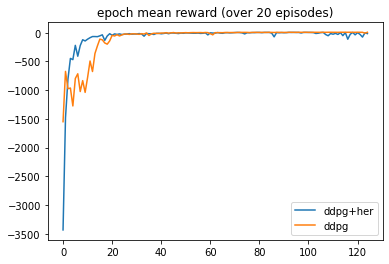

In [14]:
plt.plot(ep_mean_r, label="ddpg+her")
plt.plot(ep_mean_r_without_her, label="ddpg")
plt.legend()
plt.title("epoch mean reward (over 20 episodes)")
plt.show()

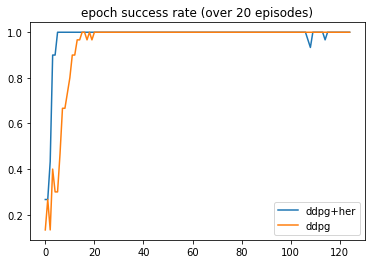

In [15]:
plt.plot(success_rate, label="ddpg+her")
plt.plot(success_rate_without_her, label="ddpg")
plt.legend()
plt.title("epoch success rate (over 20 episodes)")
plt.show()

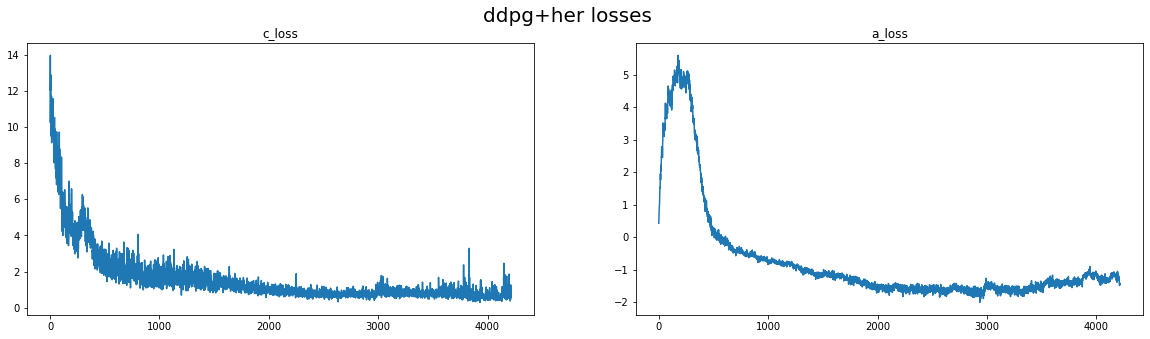

In [16]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg+her losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses)
plt.show()

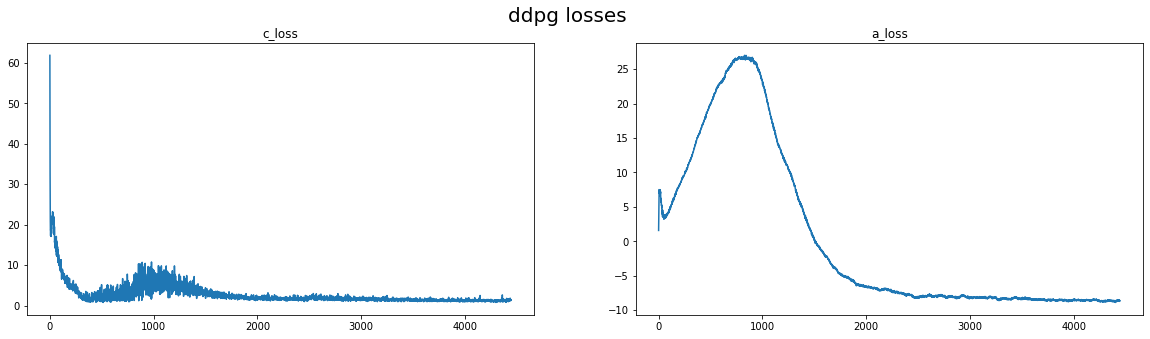

In [17]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses_without_her)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses_without_her)
plt.show()

In [18]:
env.close()